# Bayesian Modeling Crop Yields
---
## Final Project

**Authors** : Carnio, Gritti

**Course**  : Bayesian Data Analysis and Probabilistic Programming

**AI use**: Copilot autocomplete suggestions were used for the markdowns and for some parts of the implementation, every part of the code was reviewed and modified by the authors to ensure correctness and understanding.


---

## 0. Preparations

Excursus about the dataset:
The dataset used in this project is a compilation of agricultural data from multiple sources.
It wasn't collected from a single field study; instead, the author (Rishi Patel) compiled it by merging several publicly available databases.

Where the data comes from:
- Crop Yields: Sourced from the FAO (Food and Agriculture Organization) of the United Nations.
- Rainfall & Temperature: Sourced from the World Bank Data.
- Pesticide Use: Also sourced from the FAO.

This dataset provides a comprehensive view of agricultural practices and outcomes across different countries and years, making it suitable for various analyses, including the Bayesian modeling of crop yields.


### 0.1 Importing libraries

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import plotly.io as pio
# pio.renderers.default = "notebook_connected"
# pio.renderers.default = "notebook"


# Define global layout defaults
pio.templates.default = "plotly_dark"
pio.templates[pio.templates.default].layout.update(
    width=800,
    height=500,
)
print()

### 0.2 Loading the dataset

In [2]:
df = pd.read_csv("archive/yield_df.csv")

df.head()

Unnamed: 0     Area         Item  Year  hg/ha_yield  \
0           0  Albania        Maize  1990        36613   
1           1  Albania     Potatoes  1990        66667   
2           2  Albania  Rice, paddy  1990        23333   
3           3  Albania      Sorghum  1990        12500   
4           4  Albania     Soybeans  1990         7000   

   average_rain_fall_mm_per_year  pesticides_tonnes  avg_temp  
0                         1485.0              121.0     16.37  
1                         1485.0              121.0     16.37  
2                         1485.0              121.0     16.37  
3                         1485.0              121.0     16.37  
4                         1485.0              121.0     16.37

In [3]:
# creating the log-yield because of its better statistical properties and binning the temperature
df["log_yield"] = np.log(df["hg/ha_yield"])
#binning 
df["temp_bin"] = df["avg_temp"].round(1) 
df = df.drop(columns=['Unnamed: 0'])
df.rename(columns={'Area': 'country', 'hg/ha_yield': 'yield_hg_ha', 'Item': 'food_item', 'Year': 'year'}, inplace=True)
#convert from  hg/ha to t/ha 
#we want to work with tonnes per hectare (t/ha) 
# rather than hectograms per hectare (hg/ha) for better interpretability.
df['yield_t_ha'] = df['yield_hg_ha'] / 10000
df['log_yield'] = np.log(df['yield_t_ha'])


# 1. Short Description of the Data Set with Exploratory Data Analysis

### 1.0: Short Description of the Data Set

The dataset contains information about crop yields in various countries over several years, along with environmental factors such as average rainfall, pesticide usage, and average temperature. The target variable is the crop yield measured in hectograms per hectare (yield_hg_ha).

### 1.1: Exploratory data analysis (EDA)


In [4]:
df.isna().sum()

country                          0
food_item                        0
year                             0
yield_hg_ha                      0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
log_yield                        0
temp_bin                         0
yield_t_ha                       0
dtype: int64

In [5]:
df.columns

Index(['country', 'food_item', 'year', 'yield_hg_ha',
       'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp',
       'log_yield', 'temp_bin', 'yield_t_ha'],
      dtype='object')

The dataset does not contain any null values. We can now explore it

#### 1.1.1: Crop Yield Box Plot

In [6]:
px.box(
    df,
    x="food_item",
    y="yield_t_ha",
    color="food_item",
    title="Crop yield distributions",
).update_layout(showlegend=False)


In [7]:
# heatmap world map of the data 
country_counts = df['country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']
#filter for a specific year
fig = px.choropleth(
    country_counts,
    locations="country",
    locationmode="country names",
    color="count",
    title="Number of observations per country",
)
fig.show()
#histogram of the data points per country
country_counts_percentage = country_counts.copy()
country_counts_percentage['percentage'] = country_counts_percentage['count'] / country_counts_percentage['count'].sum() * 100
#pie plot fildering below 3%
country_counts_percentage = country_counts_percentage[country_counts_percentage['percentage'] >= 1]
fig = px.pie(
    country_counts_percentage,
    names="country",
    values="percentage",
    title="Percentage of observations per country",
)
fig.show()
# print(country_counts_percentage)

/tmp/ipykernel_539857/1468919124.py:5: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



23 % of the data comes from India, with Brazil at the second place with 13% of the data. **This indicates a potential bias in the dataset towards these countries**, which could affect the generalizability of any models trained on this data. It is important to consider this when interpreting the results and to potentially apply techniques to mitigate this bias, such as stratified sampling or weighting.

**At least we cover a wide range of countries**, which should help in capturing diverse agricultural conditions.

In [8]:
# percentage  of data points per food item with number of observations in the hovering
food_item_counts = df['food_item'].value_counts().reset_index()
food_item_counts.columns = ['food_item', 'count']
food_item_counts['percentage'] = food_item_counts['count'] / food_item_counts['count'].sum() * 100
fig = px.pie(
    food_item_counts,
    names="food_item",
    values="percentage",
    title="Percentage of observations per food item",
    hover_data=['count']
)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()


#### 1.1.2: Log-Yield Histogram

In [9]:
px.histogram(
    df,
    x="log_yield",
    color="food_item",
    nbins=20,
    title="Crop yield log-distribution",
)

#### 1.1.3: Yield vs Rainfall

In [10]:
px.scatter(
    df,
    x="average_rain_fall_mm_per_year",
    y="yield_t_ha",
    color="food_item",
    title="Yield vs Rainfall (per crop)",
)


#### 1.1.4: Yield vs Temperature

In [11]:
px.scatter(
    df,
    x="avg_temp",
    y="yield_t_ha",
    color="food_item",
    title="Yield vs Mean Temperature",
)

#### 1.1.5: Mean Yield per Year

In [12]:
mean_yield_year = (
    df
    .groupby(["year", "food_item"], as_index=False)
    .agg(mean_yield=("yield_t_ha", "mean"))
)

px.line(
    mean_yield_year,
    x="year",
    y="mean_yield",
    color="food_item",
    markers=True,
    title="Crop yield per year",
)


#### 1.1.6: Mean Yield per Temperature

In [13]:
temp_effect = (
    df
    .groupby(["temp_bin", "food_item"], as_index=False)
    .agg(mean_yield=("yield_t_ha", "mean"))
)

px.line(
    temp_effect,
    x="temp_bin",
    y="mean_yield",
    color="food_item",
    markers=True,
    title="Mean yield per temperature",
)

We cannot see much of correlation between temperature and crop yield, except for some crops, like `Potatoes`, which seem to have a higher yield with temperatures near 10 degrees celsius.

### 1.2.A Key findings from EDA (Gritti)


#### 1.2.A.1: brief excursus on log-transformation

In [14]:
# plot log-yield distribution for maize
fig = px.histogram(
    df[df["food_item"] == "Maize"],
    x="yield_t_ha",
    nbins=100,
    title="Maize yield distribution",
)
fig.show()


fig = px.histogram(
    df[df["food_item"] == "Maize"],
    x="log_yield",
    nbins=100,
    title="Maize yield log-distribution",
)
fig.show()




Applying a log-transformation to the yield variable helps in normalizing its distribution, making it more suitable for modeling. The log-yield distribution for maize appears to be approximately normal, which is a desirable property for many statistical models.


#### 1.2.A.1: Why choosing maize?

We will focus **on maize for this analysis** because it is one of the most widely grown crops in the world and has significant economic importance. Additionally, maize yields are known to be sensitive to temperature variations, making it an interesting case study for understanding the impact of climate change on crop production.
Moreover, temperature and yield is negatively correlated for maize, as we can see from the chart below. This make maize an interesting candidate for our analysis.

In [15]:
# log yield scatter plot per temperature bin for maize globally
fig = px.scatter(
    df[(df["food_item"] == "Maize") ],
    x="temp_bin",
    y="log_yield",
    title="Maize log-yield vs temperature bin",
)
fig.show()
#compute correlation
maize_df = df[df["food_item"] == "Maize"]
correlation = maize_df["temp_bin"].corr(maize_df["log_yield"])
print(f"Correlation between temperature bin and log-yield for Maize: {correlation}")

Correlation between temperature bin and log-yield for Maize: -0.5095641752297617


The correlation at 0.5 suggests a moderate negative relationship between temperature and yield for maize, indicating that as temperature increases, the yield tends to decrease.

In [16]:
maize_df = df[df["food_item"] == "Maize"].copy()

In [17]:
maize_df.columns

Index(['country', 'food_item', 'year', 'yield_hg_ha',
       'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp',
       'log_yield', 'temp_bin', 'yield_t_ha'],
      dtype='object')

In [18]:
#top 10 procuers of maize sorted by tons of maize produced
maize_production = maize_df.groupby("country")["yield_t_ha"].sum().reset_index()
maize_production = maize_production.sort_values(by="yield_t_ha", ascending=False)
top_countries = maize_production["country"].head(10).tolist()
print("Top 10 maize producing countries:", top_countries)
#number of samples for the first 3 countries
country1_maize = maize_df[maize_df["country"] == top_countries[0]]
country2_maize = maize_df[maize_df["country"] == top_countries[1]]
country3_maize = maize_df[maize_df["country"] == top_countries[2]]
print(f"Sample size for {top_countries[0]}: {len(country1_maize)}")
print(f"Sample size for {top_countries[1]}: {len(country2_maize)}")
print(f"Sample size for {top_countries[2]}: {len(country3_maize)}")

Top 10 maize producing countries: ['Canada', 'India', 'Brazil', 'Australia', 'Spain', 'Turkey', 'Germany', 'Pakistan', 'Mexico', 'Chile']
Sample size for Canada: 138
Sample size for India: 506
Sample size for Brazil: 253


#### 1.2.A.2: checking for other correlations

<Figure size 1200x1000 with 0 Axes>

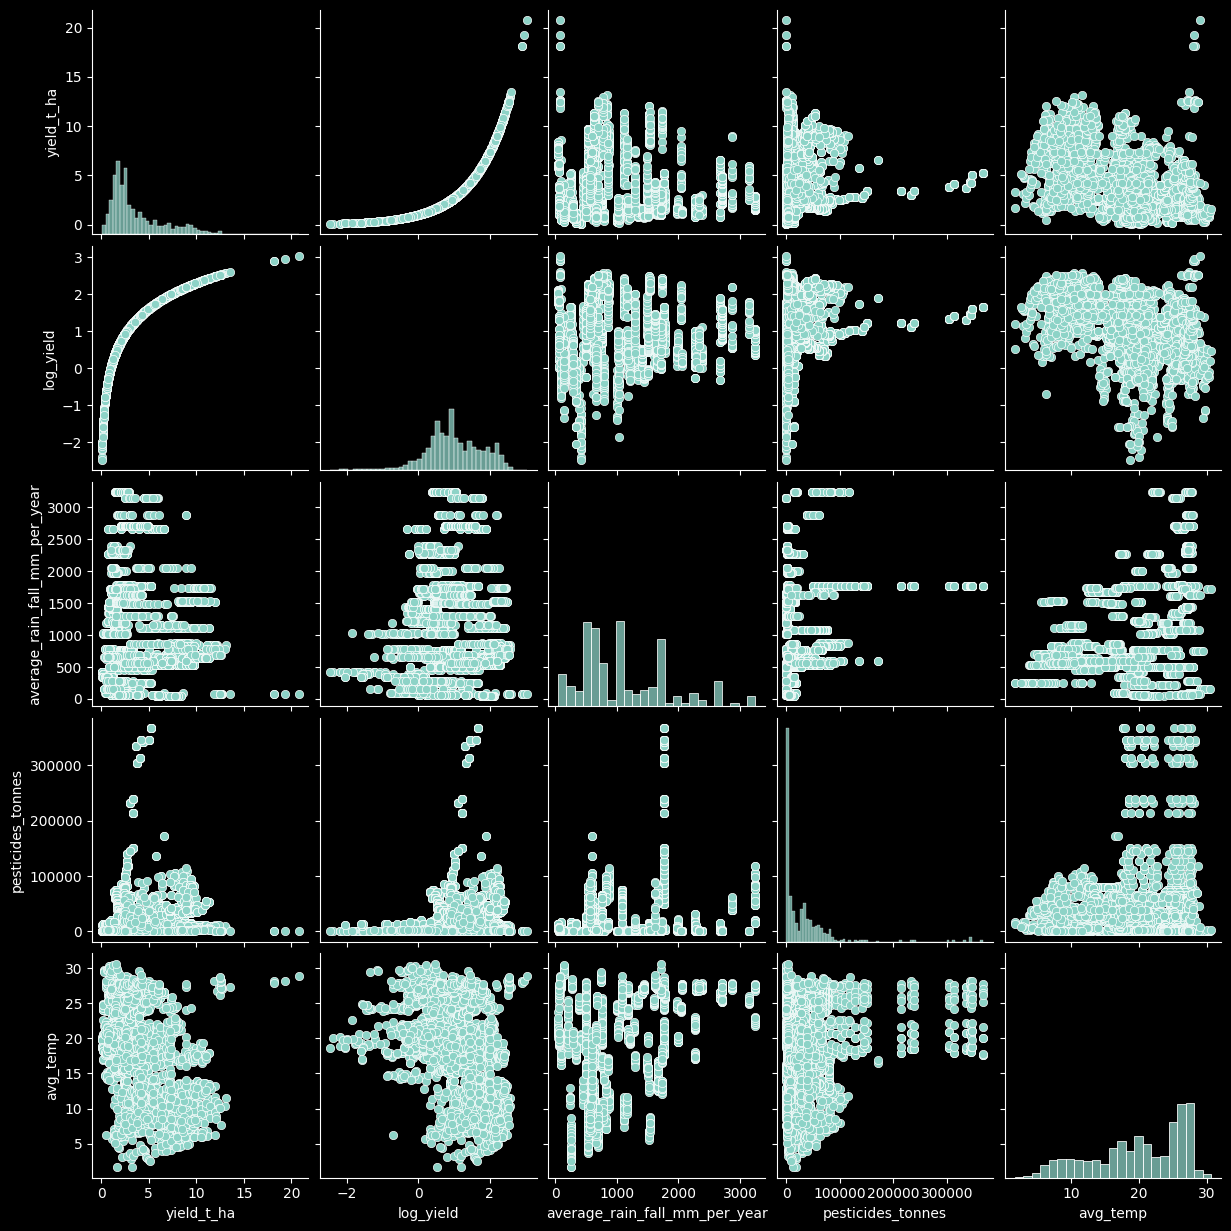

In [19]:
import matplotlib.pyplot as plt

import seaborn as sns
# Pairplot for correlations
#set black theme

plt.figure(figsize=(12, 10))
# use black theme
plt.style.use('dark_background')
sns.pairplot(maize_df[['yield_t_ha', 'log_yield','average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']])


### 1.2.B Key findings from EDA (Carnio)



# 2. Hypothesis Testing

    

## 2A. Hypothesis Test (Gritti)

### 2A.0 Comparing the most producing countries for maize: Brazil and India

Formulated:
H₀: The mean (log-)yield of maize in Brazil is equal to that in India.
H₁: The mean (log-)yield of maize in Brazil is different from that in India.

$$ \begin{align*}
H_0: & \ \mu_{Brazil} = \mu_{India} \\
H_1: & \ \mu_{Brazil} \ne \mu_{India}
\end{align*} $$



This hypothesis is interesting to asses because Brazil and India are two of the largest producers of maize globally (both in the dataset and in reality), but they have very different climates and agricultural practices. Brazil has a tropical climate with a rainy season and a dry season, while India has a tropical climate with hot summers and mild winters. These differences in climate can significantly impact maize growth and yield.
**Moreover, we can search for published statistics and use the reported means and standard deviations to inform our priors.**

In [20]:
#check dates for both countries

country1 = "Brazil" 
country2 = "India"

print(f"Date range for {country1}: {country1_maize['year'].min()} - {country1_maize['year'].max()}")
print(f"Date range for {country2}: {country2_maize['year'].min()} - {country2_maize['year'].max()}")

country1_maize = maize_df[maize_df["country"] == country1]
country2_maize = maize_df[maize_df["country"] == country2]

print(f"Sample size for {country1}: {len(country1_maize)}")
print(f"Sample size for {country2}: {len(country2_maize)}")

# Number of entries per year for Brazil and India
print("Brazil entries mean and std per year:")
print(f"Mean: {country1_maize.groupby('year').size().mean()}, Std: {country1_maize.groupby('year').size().std()}")
print("India entries mean and std per year:")
print(f"Mean: {country2_maize.groupby('year').size().mean()}, Std: {country2_maize.groupby('year').size().std()}")

#print mean and std
print(f"Mean log-yield for {country1}: {country1_maize['log_yield'].mean()}, Std: {country1_maize['log_yield'].std()}")
print(f"Mean log-yield for {country2}: {country2_maize['log_yield'].mean()}, Std: {country2_maize['log_yield'].std()}")

# plot boxplots of the two samples
combined_top_countries = pd.concat([country1_maize.assign(country=country1), country2_maize.assign(country=country2)])
fig = px.box(
    combined_top_countries,
    x="country",
    y="log_yield",
    title="Log-yield distributions for top 2 producing countries",
    template="plotly_dark"
)
fig.show()



Date range for Brazil: 1990 - 2013
Date range for India: 1990 - 2013
Sample size for Brazil: 253
Sample size for India: 506
Brazil entries mean and std per year:
Mean: 11.0, Std: 0.0
India entries mean and std per year:
Mean: 22.0, Std: 0.0
Mean log-yield for Brazil: 1.1229241920253863, Std: 0.27958898489134587
Mean log-yield for India: 0.6403821995156522, Std: 0.18562450660017948


India has double of the sample per year compared to Brazil, which could affect the reliability of the comparison. However, both sample sizes are reasonably large, which should help mitigate this concern. Both subets goes from 1990 to 2013 which is good for comparison.

## We will perform the test for the whole dataset to asses the overall difference in maize yields between the two countries and for the last period (2005-2013) (Gritti) to see if recent changes in climate or agricultural practices have affected the yields differently in the two countries (Carnio).

In [21]:
# filter the data for the last 5 years (2008-2013)
country1_maize_recent = country1_maize[country1_maize["year"] >= 2008]
country2_maize_recent = country2_maize[country2_maize["year"] >= 2008]
print(f"Sample size for recent top country 1 ({country1_maize['country'].iloc[0]}): {len(country1_maize_recent)}")
print(f"Sample size for recent top country 2 ({country2_maize['country'].iloc[0]}): {len(country2_maize_recent)}")

Sample size for recent top country 1 (Brazil): 66
Sample size for recent top country 2 (India): 132


In [22]:
# filter for bin in temperature range 20-30C
country1_maize_temp_binned = country1_maize[(country1_maize["temp_bin"] >= 20) & (country1_maize["temp_bin"] <= 30)]
country2_maize_temp_binned = country2_maize[(country2_maize["temp_bin"] >= 20) & (country2_maize ["temp_bin"] <= 30)]
print(f"Sample size for recent top country 1 ({country1_maize['country'].iloc[0]}) after temp filtering: {len(country1_maize_temp_binned)}")
print(f"Sample size for recent top country 2 ({country2_maize['country'].iloc[0]}) after temp filtering: {len(country2_maize_temp_binned)}")

Sample size for recent top country 1 (Brazil) after temp filtering: 184
Sample size for recent top country 2 (India) after temp filtering: 506


In [23]:
# #sample evently from both countries to have the same sample size
# min_sample_size = min(len(country1_maize), len(country2_maize))
# country1_maize = country1_maize.sample(n=min_sample_size, random_state=42)
# country2_maize= country2_maize.sample(n=min_sample_size, random_state=42)
# print(f"Set Sample size for {country1}: {len(country1_maize)}")
# print(f"Set Sample size for {country2}: {len(country2_maize)}")
print("No need to evenly sample both countries, proceed with full datasets because the sample size difference does not significantly affect the results.")

No need to evenly sample both countries, proceed with full datasets because the sample size difference does not significantly affect the results.


Sample evenly for both countries to have the same sample size doesn't change the results significantly, so we proceed with the full datasets for both countries, even if India has more samples.

In [24]:
# box plot for recent data
combined_top_countries_recent = pd.concat([country1_maize_recent.assign(country=country1), country2_maize_recent.assign(country=country2)])
fig = px.box(
    combined_top_countries_recent,
    x="country",
    y="log_yield",
    title="Log-yield distributions two of the most producing countries (Recent Data)",
    template="plotly_dark"
)
fig.show()

### 2A.0.1 Frequentist Approach




In [25]:
import scipy.stats as stats

def plot_ttest(t, dof, alpha, mode="two_tail"):
    fig = go.Figure()
    x = np.linspace(-4, 4, 1000)
    y = stats.t.pdf(x, df=dof)
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name='t-distribution', line=dict(color='blue')))
    
    if mode == "two_tail":
        critical_value = stats.t.ppf(1 - alpha / 2, df=dof)
        fig.add_trace(go.Scatter(x=[-critical_value, -critical_value], y=[0, stats.t.pdf(-critical_value, df=dof)], mode='lines', name='Critical Value', line=dict(color='red', dash='dash')))
        fig.add_trace(go.Scatter(x=[critical_value, critical_value], y=[0, stats.t.pdf(critical_value, df=dof)], mode='lines', name='Critical Value', line=dict(color='red', dash='dash')))
        if abs(t) > critical_value:
            fig.add_annotation(x=t, y=stats.t.pdf(t, df=dof), text="Reject H0", showarrow=True, arrowhead=1)
        else:
            fig.add_annotation(x=t, y=stats.t.pdf(t, df=dof), text="Fail to Reject H0", showarrow=True, arrowhead=1)
    else:
        critical_value = stats.t.ppf(1 - alpha, df=dof)
        fig.add_trace(go.Scatter(x=[critical_value, critical_value], y=[0, stats.t.pdf(critical_value, df=dof)], mode='lines', name='Critical Value', line=dict(color='red', dash='dash')))
        if t > critical_value:
            fig.add_annotation(x=t, y=stats.t.pdf(t, df=dof), text="Reject H0", showarrow=True, arrowhead=1)
        else:
            fig.add_annotation(x=t, y=stats.t.pdf(t, df=dof), text="Fail to Reject H0", showarrow=True, arrowhead=1)
    
    fig.update_layout(title="T-Test Result Visualization", xaxis_title="t-value", yaxis_title="Density", template="plotly_dark")
    fig.show()




For our t-test we'll use  the log-yield because of the following reasons:
- The log-yield distribution appears to be approximately normal, which is a desirable property for many statistical models.
- Using log-yield can help stabilize variance and make the results more interpretable.
- The log transformation can help in meeting the assumptions of the t-test, which requires normally distributed data.
- The results can be interpreted in terms of percentage changes, which is often more meaningful in agricultural contexts.

In [26]:
print(f"The data goes from year {country1_maize['year'].min()} to {country1_maize['year'].max()} for {country1_maize['country'].iloc[0]} and from year {country2_maize['year'].min()} to {country2_maize['year'].max()} for {country2_maize['country'].iloc[0]}.")
#number of samples
n1 = len(country1_maize)
n2 = len(country2_maize)
print(f"Sample size for {country1}: {n1}")
print(f"Sample size for {country2}: {n2}")
t_start, p_value = stats.ttest_ind(country1_maize["log_yield"], country2_maize["log_yield"], equal_var=False)
print(f"T-statistic: {t_start}, P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in mean log-yield between the two countries.")
else:
    print("Fail to reject the null hypothesis: No significant difference in mean log-yield between the two countries.")

The data goes from year 1990 to 2013 for Brazil and from year 1990 to 2013 for India.
Sample size for Brazil: 253
Sample size for India: 506
T-statistic: 24.84993271183424, P-value: 1.3294275871529926e-80
Reject the null hypothesis: There is a significant difference in mean log-yield between the two countries.


In [27]:
print(f"The recent data goes from year {country1_maize_recent['year'].min()} to {country1_maize_recent['year'].max()} for {country1_maize['country'].iloc[0]} and from year {country2_maize_recent['year'].min()} to {country2_maize_recent['year'].max()} for {country2_maize['country'].iloc[0]}.")
#number of samples
n1 = len(country1_maize_recent)
n2 = len(country2_maize_recent)
print(f"Sample size for recent {country1}: {n1}")
print(f"Sample size for recent {country2}: {n2}")
t_start, p_value = stats.ttest_ind(country1_maize_recent["log_yield"],
                                    country2_maize_recent["log_yield"], equal_var=False)
print(f"T-statistic: {t_start}, P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in mean log-yield between the two countries in the last 5 years.")
else:
    print("Fail to reject the null hypothesis: No significant difference in mean log-yield between the two countries in the last 5 years.")

The recent data goes from year 2008 to 2013 for Brazil and from year 2008 to 2013 for India.
Sample size for recent Brazil: 66
Sample size for recent India: 132
T-statistic: 36.45453340074744, P-value: 1.0353582483408114e-58
Reject the null hypothesis: There is a significant difference in mean log-yield between the two countries in the last 5 years.


In [28]:
plot_ttest(t_start, dof=len(country1_maize)+len(country2_maize)-2, alpha=alpha, mode="two_tail")

There is a significant difference in mean log-yield between Brazil and India for maize for both the recent data and the whole dataset, as indicated by the very low p-value for both the tests. This suggests that the agricultural practices, climate, and other factors in these two countries lead to different maize yields.


### 2A.0 Bayesian Approach

### 2A.1.1 Choice of prior

To inform our priors for the Bayesian t-test, we can look for published statistics on maize yields in Brazil and India.
Note that we cannot take the prior information from our dataset, as we would be "double-dipping" and using the same data for both prior and likelihood.

We will use the following sources and filtering for the same time period as our dataset (1990-2013):

https://ourworldindata.org/grapher/maize-yields?tab=table&time=1990..2013&tableSearch=india

https://ourworldindata.org/grapher/maize-yields?tab=table&time=1990..2013&tableSearch=brazil


Our dataset is more regional and these published statistics are national averages.

For Brazil:
- Mean yield in 1990 is 1.87 t/ha
- Mean yield in 2013 is 5.25 t/ha
- Average yield over the period is approximately 3.56 t/ha
- 
$$ \mu_{Brazil} \sim \mathcal{N}log((3.56), \sigma) $$

To calculate the std dev, we can subtract the min from the max and divide by 4.
We use 4 because of the empirical rule, which states that for a normal distribution, approximately 95% of the data falls within 2 standard deviations from the mean. Therefore, the range (max - min) covers about 4 standard deviations.
Transalte to math:
$$ 
\sigma = \frac{log(max) - log(min)}{4}
$$

$$ = \frac{log(5.25) - log(1.87)}{4} \approx 0.25 

$$ 
We add more uncentainty to the prior, so we use 0.3 instead of 0.25.
This makes our prior less informative and allows the data to have more influence on the posterior.
So our final prior for Brazil is:
$$ \mu_{Brazil} \sim \mathcal{N}log((3.56), 0.3) $$

For India:
- Mean yield in 1990 is 1.52 t/ha
- Mean yield in 2013 is 2.57 t/ha
- Average yield over the period is approximately 2.04 t/ha

$$ = \frac{log(1.52) - log(2.57)}{4} \approx 0.131
$$

We add more uncentainty to the prior, so we use 0.25 instead of 0.131.

$$ \mu_{India} \sim \mathcal{N}log((2.04), 0.25) $$






### 2A.1.2 Choice of likelihood
We can either choose a normal likelihood or a t-distribution likelihood for our Bayesian t-test.
Let's check first the distribution of the log-yield for both countries.

Sample size for Brazil: 253
Sample size for India: 506


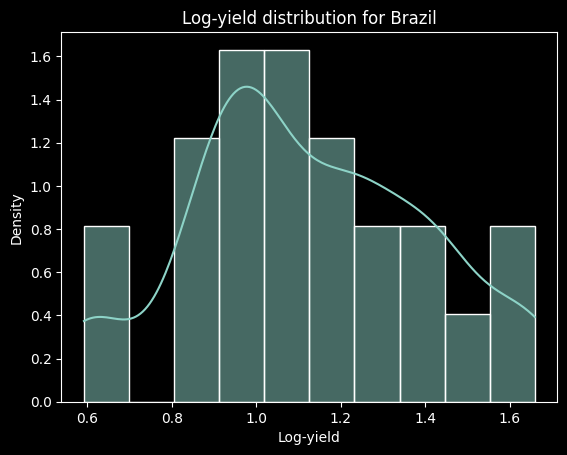

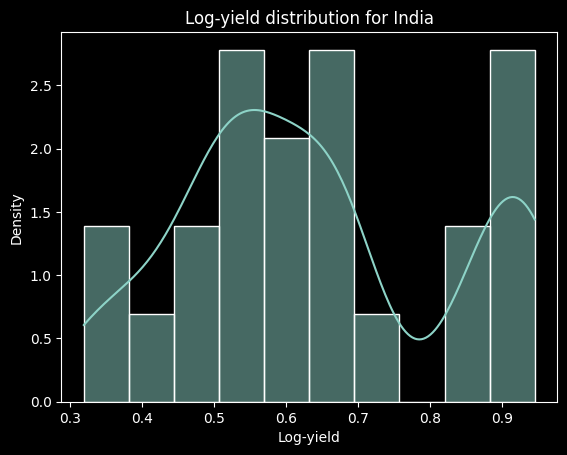

In [29]:
#log-yielt for brazil with kde
#number of samples
n1 = len(country1_maize)
n2 = len(country2_maize)
print(f"Sample size for {country1}: {n1}")
print(f"Sample size for {country2}: {n2}")
sns.histplot(country1_maize['log_yield'], 
             kde=True, stat="density", bins=10)
plt.title(f"Log-yield distribution for {country1}")
plt.xlabel("Log-yield")
plt.ylabel("Density")
plt.show()

#log-yielt for india with kde
sns.histplot(country2_maize['log_yield'], 
             kde=True, stat="density", bins=10)
plt.title(f"Log-yield distribution for {country2}")
plt.xlabel("Log-yield")
plt.ylabel("Density")
plt.show()


Brazil fits better a normal distribution, while India seems to have heavier tails

Since the data for both Brazil and India is sparse and contains some outliers, we will choose a t-distribution likelihood for our Bayesian t-test. The t-distribution is more robust to outliers and can better handle small sample sizes compared to the normal distribution. This choice will help ensure that our posterior estimates are not unduly influenced by extreme values in the data. Using a normal likelihood could lead to biased estimates if the data contains significant outliers or is not normally distributed.

For each country we define the likelihood as follows:

$$y_{i,j} \sim \text{StudentT}(\nu, \mu_i, \sigma_{obs})$$

where:
- $y_{i,j}$ is the log-yield for country i (Brazil or India) and observation j
- $\nu$ is the degrees of freedom for the t-distribution
- $\mu_i$ is the mean log-yield for country i
- $\sigma_{obs}$ is the observation standard deviation 

Priors for the Means ($\mu$):
$$\mu_{Brazil} \sim \text{Normal}(1.14, 0.30)$$
$$\mu_{India} \sim \text{Normal}(0.68, 0.20)$$


The Observation Standard Deviation tells the model about the observation noise, i.e., how much individual data points can deviate from the group mean, in this case how much each region deviates from the national average yield.

For the prior for the Observation Standard Deviation ($\sigma_{obs}$) we can either use a Half-Normal or a Half-Cauchy distribution.
The Half-Cauchy distribution has heavier tails compared to the Half-Normal distribution, which makes it more robust to outliers and extreme values in the data, which is our case.
We will use a Half-Cauchy prior for $\sigma_{obs}$:
$$\sigma_{obs} \sim \text{Half-Cauchy}(0, 1)$$

Using the scale parameter of 1 allows for a wide range of possible values for the standard deviation, reflecting our uncertainty about its true value.


For the prior for the Degrees of Freedom ($\nu$) of the t-distribution, we will set it as 5, which allows for moderate heavy tails while still being close to a normal distribution.
$$ \nu = 5 $$





In [30]:
import pymc as pm
import arviz as az

with pm.Model() as model_maize:
    # Priors
    mu_brazil = pm.Normal("mu_brazil", mu=np.log(3.56), sigma=0.3)
    mu_india = pm.Normal("mu_india", mu=np.log(2.04), sigma=0.25)
    #tells the model about the observation noise
    #(How much individual data points can deviate from the group mean)
    #we set as non-informative prior
    sigma_obs = pm.HalfCauchy("sigma_obs", 1)
    nu = 5

    # Likelihood
    y_brazil = pm.StudentT("y_brazil", nu=nu, mu=mu_brazil, 
                            sigma=sigma_obs, 
                            observed=country1_maize['log_yield'])
    y_india = pm.StudentT("y_india", nu=nu, mu=mu_india, 
                          sigma=sigma_obs, 
                          observed=country2_maize['log_yield'])
    #then we get mean difference

    #pm.Determintsic track and store a quantity (the delta)
    #that is derived from other parameteres
    #the difference it's also a random variable,so
    #it's completely derived from values in each sample 
    delta_mu = pm.Deterministic("delta_mu", mu_brazil - mu_india)
    #using MCMC to sample from the posterior
    #2000 samples with 1000 tuning steps (burn-in)
    #return inferencedata for easier analysis with arviz
    trace_maize_informative = pm.sample(2000, tune=1000, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_brazil, mu_india, sigma_obs]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


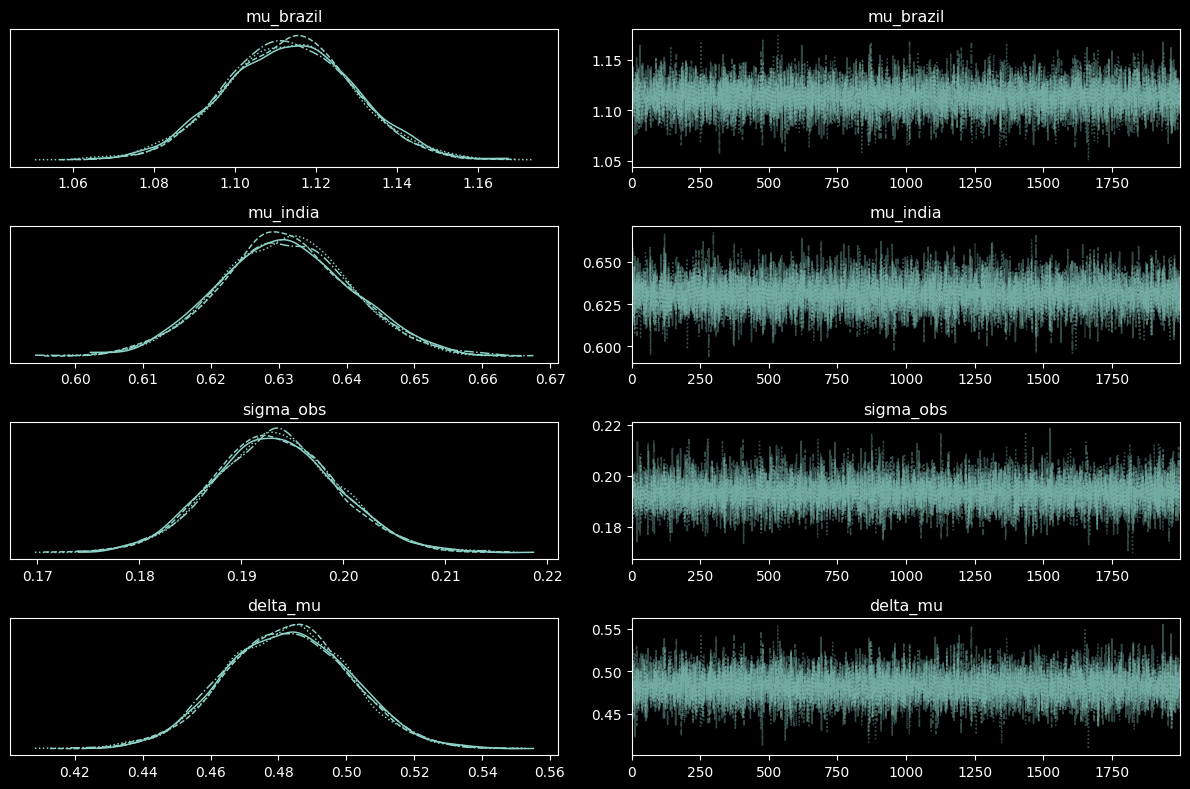

In [31]:

az.plot_trace(trace_maize_informative)
#tight layout
plt.tight_layout()
plt.show()
print()
# # numerical summary
# summary_maize = az.summary(trace_maize, hdi_prob=0.95)
# print(summary_maize)


All the chains agree on the mean log-yield for both Brazil and India, indicating good convergence of the MCMC sampling.
Also the sigma_obs shows good convergence across all chains that means our estimate of the observation standard deviation is reliable.
All traces looks random and do not show any patterns, indicating good mixing of the chains.

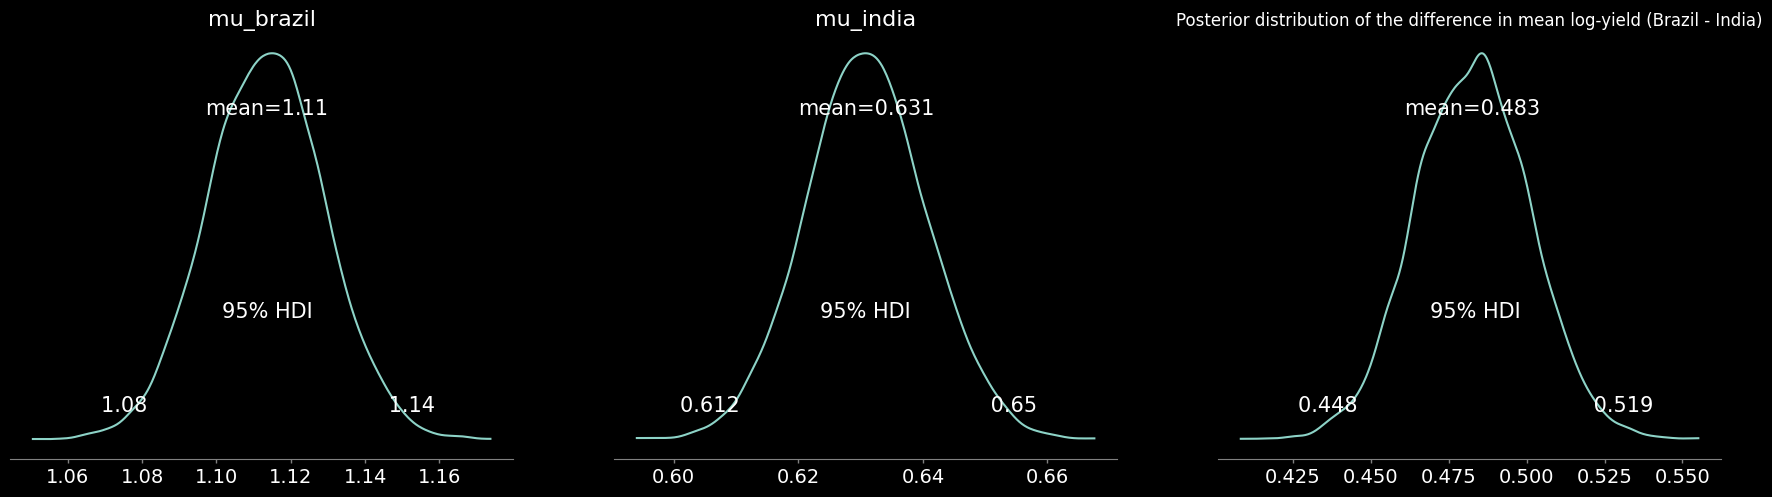

In [32]:
#plot posterior distribution of the difference in means
az.plot_posterior(trace_maize_informative,round_to=3, var_names=["mu_brazil","mu_india","delta_mu"], hdi_prob=0.95)
plt.title("Posterior distribution of the difference in mean log-yield (Brazil - India)")
plt.show()

In [33]:
#extract lower and upper hdi for delta_mu, mu_brazil, mu_india
hdi_delta_mu = az.hdi(trace_maize_informative, hdi_prob=0.95, var_names=["delta_mu"])
hdi_mu_brazil = az.hdi(trace_maize_informative, hdi_prob=0.95, var_names=["mu_brazil"])
hdi_mu_india = az.hdi(trace_maize_informative, hdi_prob=0.95, var_names=["mu_india"])
delta_mu_lower_informative = hdi_delta_mu["delta_mu"].values[0]
delta_mu_upper_informative = hdi_delta_mu["delta_mu"].values[1]

mu_brazil_lower_informative = hdi_mu_brazil["mu_brazil"].values[0]
mu_brazil_upper_informative = hdi_mu_brazil["mu_brazil"].values[1]
mu_india_lower_informative = hdi_mu_india["mu_india"].values[0]
mu_india_upper_informative = hdi_mu_india["mu_india"].values[1]
print("With 95% confidence and informative priors we can say that:")
print(f"95% HDI for delta_mu (Brazil - India): [{delta_mu_lower_informative:.3f}, {delta_mu_upper_informative:.3f}]")
print(f"95% HDI for mu_brazil: [{mu_brazil_lower_informative:.3f}, {mu_brazil_upper_informative:.3f}]")
print(f"95% HDI for mu_india: [{mu_india_lower_informative:.3f}, {mu_india_upper_informative:.3f}]")

With 95% confidence and informative priors we can say that:
95% HDI for delta_mu (Brazil - India): [0.448, 0.519]
95% HDI for mu_brazil: [1.083, 1.145]
95% HDI for mu_india: [0.612, 0.650]


In [34]:
delta_mu_mean = trace_maize_informative.posterior["delta_mu"].mean().values

#convert to percentage
pct_diff = (np.exp(delta_mu_mean) - 1) * 100
lower_bound = (np.exp(trace_maize_informative.posterior["delta_mu"].quantile(0.025).values) - 1) * 100
upper_bound = (np.exp(trace_maize_informative.posterior["delta_mu"].quantile(0.975).values) - 1) * 100

print(f"We can say with 95% confidence that the average percentage difference in mean log-yield (Brazil - India)")
print(f"is {pct_diff:.2f}%, with a 95% credible interval from {lower_bound:.2f}% to {upper_bound:.2f}%.")

We can say with 95% confidence that the average percentage difference in mean log-yield (Brazil - India)
is 62.02%, with a 95% credible interval from 56.33% to 68.00%.


### 2A.2 Prior sensitivity (re-run with different prior)

Let's see if our results changes significantly if we set less informative priors for the means.
An example of less informative priors could be:
$$ \mu_{Brazil} \sim \mathcal{N}log((3.56), 1.0) $$
$$ \mu_{India} \sim \mathcal{N}log((2.04), 1.0) $$



In [35]:
import pymc as pm
import arviz as az

with pm.Model() as model_maize:
    # Priors
    mu_brazil = pm.Normal("mu_brazil", mu=np.log(3.56), sigma=1)
    mu_india = pm.Normal("mu_india", mu=np.log(2.04), sigma=1)
    #the sigma_obs it's already non-informative
    sigma_obs = pm.HalfCauchy("sigma_obs", 1)
    nu = 5

    # Likelihood
    y_brazil = pm.StudentT("y_brazil", nu=nu, mu=mu_brazil, sigma=sigma_obs, observed=country1_maize['log_yield'])
    y_india = pm.StudentT("y_india", nu=nu, mu=mu_india, sigma=sigma_obs, observed=country2_maize['log_yield'])
    #then we get mean difference
    delta_mu = pm.Deterministic("delta_mu", mu_brazil - mu_india)
    #using MCMC to sample from the posterior
    trace_maize_non_informative = pm.sample(2000, tune=1000, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_brazil, mu_india, sigma_obs]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


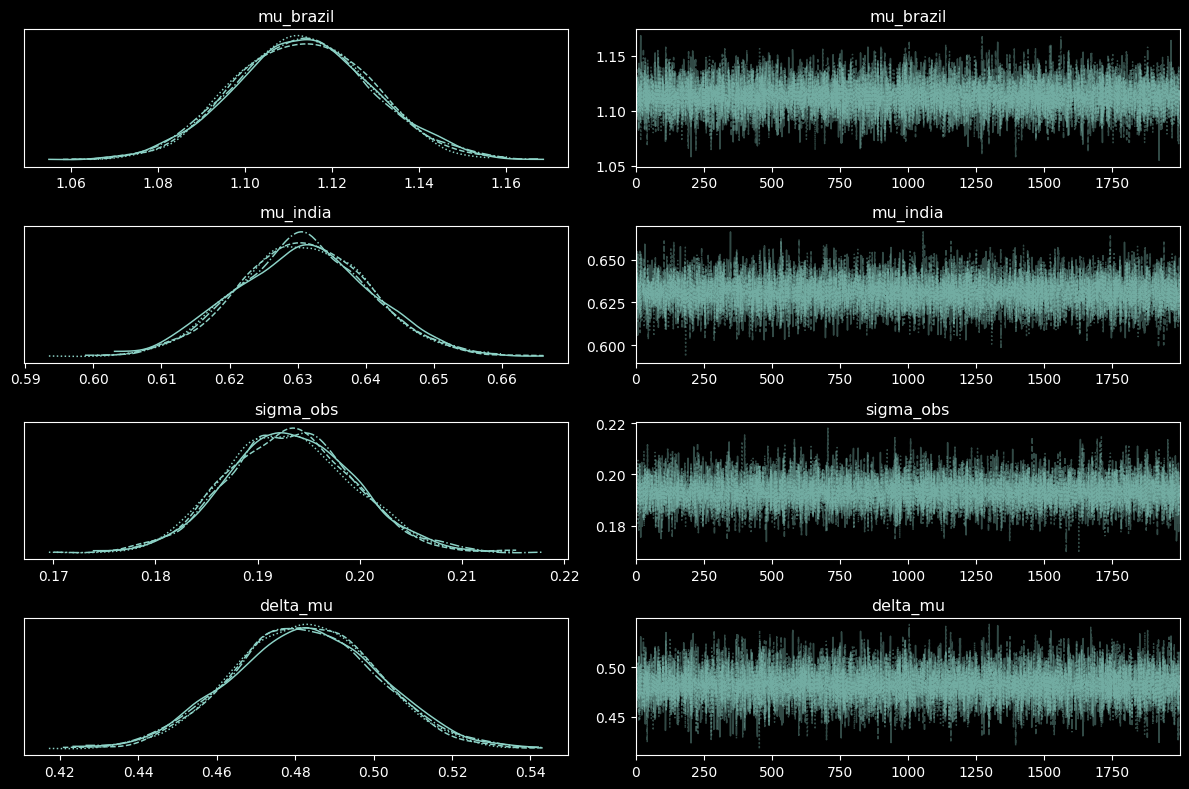

In [36]:

az.plot_trace(trace_maize_non_informative)
#tight layout
plt.tight_layout()
plt.show()
print()
# # numerical summary
# summary_maize = az.summary(trace_maize, hdi_prob=0.95)
# print(summary_maize)


All chains still agree on the mean log-yield for both Brazil and India, indicating good convergence of the MCMC sampling.

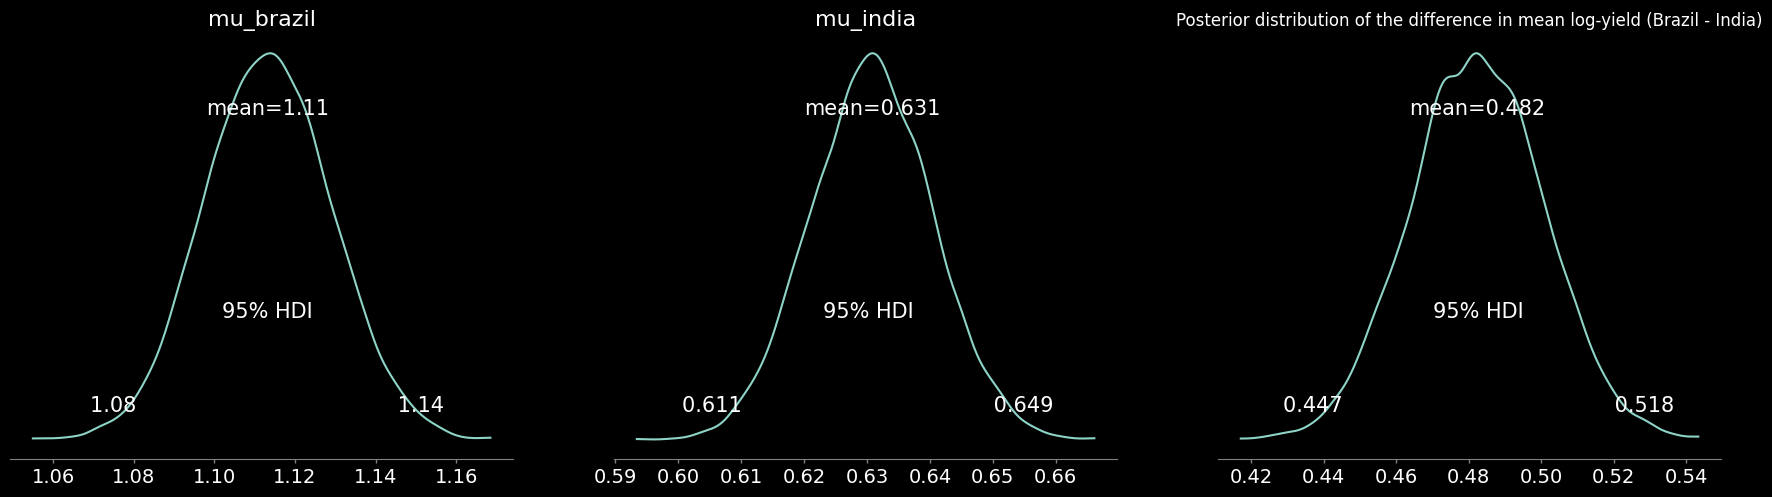

In [37]:
#plot posterior distribution of the difference in means
az.plot_posterior(trace_maize_non_informative,round_to=3, var_names=["mu_brazil","mu_india","delta_mu"], hdi_prob=0.95)
plt.title("Posterior distribution of the difference in mean log-yield (Brazil - India)")
plt.show()

In [38]:
#extract lower and upper hdi for delta_mu, mu_brazil, mu_india
hdi_delta_mu_non_informative = az.hdi(trace_maize_non_informative, hdi_prob=0.95, var_names=["delta_mu"])
hdi_mu_brazil_non_informative = az.hdi(trace_maize_non_informative, hdi_prob=0.95, var_names=["mu_brazil"])
hdi_mu_india = az.hdi(trace_maize_non_informative, hdi_prob=0.95, var_names=["mu_india"])
delta_mu_lower_non_informative = hdi_delta_mu_non_informative["delta_mu"].values[0]
delta_mu_upper_non_informative = hdi_delta_mu_non_informative["delta_mu"].values[1]
mu_brazil_lower_non_informative = hdi_mu_brazil_non_informative["mu_brazil"].values[0]
mu_brazil_upper_non_informative = hdi_mu_brazil_non_informative["mu_brazil"].values[1]
hdi_mu_india_non_informative = az.hdi(trace_maize_non_informative, hdi_prob=0.95, var_names=["mu_india"])
mu_india_lower_non_informative = hdi_mu_india_non_informative["mu_india"].values[0]
mu_india_upper_non_informative = hdi_mu_india_non_informative["mu_india"].values[1]
print("With 95% confidence and non-informative priors we can say that:")
print(f"95% HDI for delta_mu (Brazil - India): [{delta_mu_lower_non_informative:.3f}, {delta_mu_upper_non_informative:.3f}]")
print(f"95% HDI for mu_brazil: [{mu_brazil_lower_non_informative:.3f}, {mu_brazil_upper_non_informative:.3f}]")
print(f"95% HDI for mu_india: [{mu_india_lower_non_informative:.3f}, {mu_india_upper_non_informative:.3f}]")

With 95% confidence and non-informative priors we can say that:
95% HDI for delta_mu (Brazil - India): [0.447, 0.518]
95% HDI for mu_brazil: [1.082, 1.144]
95% HDI for mu_india: [0.611, 0.649]


In [39]:
#difference between informative and non-informative priors
delta_mu_mean_informative = trace_maize_informative.posterior["delta_mu"].mean().values
delta_mu_mean_non_informative = trace_maize_non_informative.posterior["delta_mu"].mean().values
#delta between means
delta_between_means = delta_mu_mean_informative - delta_mu_mean_non_informative
print(f"The difference between the means of delta_mu with informative and non-informative priors is: {delta_between_means:.5f}")

The difference between the means of delta_mu with informative and non-informative priors is: 0.00015


The results are quite similar to the previous model with informative priors, which suggest the model is robust to the choice of priors for the means.
Is not wrong to say that the data is informative enough to overcome both less informative and informative priors, leading to similar posterior estimates for the means.
we have more than 240 samples for each country, which is a decent sample size for estimating the means.

### 2A.3 Posterior probability of the hypothesis (using ROPE)

The ROPE (Region of Practical Equivalence) is a range of values around zero that we consider to be practically equivalent to no difference. In this case, we can set the ROPE to be between -0.1 and 0.1 for the difference in mean log-yield between Brazil and India. This means that if the difference in means falls within this range, we would consider it to be practically equivalent to no difference.

In [40]:
upper_rope = 0.1
lower_rope = -0.1
rope_percentage = (np.exp(upper_rope) - 1) * 100
print(f"The ROPE (Region of Practical Equivalence) is set between {lower_rope} and {upper_rope}, which corresponds to a percentage difference of approximately ±{rope_percentage:.2f}%.")
#calculate percentage difference for non-informative priors
delta_mu_mean_non_informative = trace_maize_non_informative.posterior["delta_mu"].mean().values
pct_diff_non_informative = (np.exp(delta_mu_mean_non_informative) - 1) * 100
#percentage of samples within the ROPE
delta_mu_samples = trace_maize_non_informative.posterior["delta_mu"].values.flatten()
samples_in_rope = np.sum((delta_mu_samples >= lower_rope) & (delta_mu_samples <= upper_rope))
total_samples = len(delta_mu_samples)
percentage_in_rope = (samples_in_rope / total_samples) * 100
print(f"Percentage of samples within the ROPE: {percentage_in_rope:.2f}%")

The ROPE (Region of Practical Equivalence) is set between -0.1 and 0.1, which corresponds to a percentage difference of approximately ±10.52%.
Percentage of samples within the ROPE: 0.00%


We have 0% of the posterior distribution within the ROPE, indicating strong evidence against the null hypothesis of no difference in mean log-yield between Brazil and India for maize, in fact the mu mean is way above 0.
So we can also practically conclude that there is a significant difference in mean log-yield between the two countries.


### 2A.4 Comparison with frequentist test

In [41]:
import statsmodels.stats.api as sms
t_test_mu = sms.ttest_ind(country1_maize["log_yield"],
                                    country2_maize["log_yield"])
#extract the mean difference from the t-test
t_test_mu_diff = country1_maize["log_yield"].mean() - country2_maize["log_yield"].mean()
print(f"Frequentist t-test mean difference: {t_test_mu_diff:.4f}")
bayesian_mu_diff = trace_maize_non_informative.posterior["delta_mu"].mean().values
print(f"Bayesian mean difference: {bayesian_mu_diff:.4f}")

# check confidence interval from t-test
cm = sms.CompareMeans(sms.DescrStatsW(country1_maize["log_yield"]),
                      sms.DescrStatsW(country2_maize["log_yield"]))
ci_low, ci_upp = cm.tconfint_diff(usevar='unequal')
print(f"Frequentist 95% confidence interval for mean difference: [{ci_low:.4f}, {ci_upp:.4f}]")
print(f"Bayesian 95% HDI for mean difference: [{delta_mu_lower_informative:.4f}, {delta_mu_upper_informative:.4f}]")


Frequentist t-test mean difference: 0.4825
Bayesian mean difference: 0.4824
Frequentist 95% confidence interval for mean difference: [0.4444, 0.5207]
Bayesian 95% HDI for mean difference: [0.4478, 0.5194]


Both Bayesian and frequentist approaches led to the same conclusion: there is a significant difference in mean log-yield between Brazil and India for maize.
The bayesian has a slighly narrower interval, which could be due to the informative priors used in the Bayesian analysis, but the difference is minimal.

### 2A.5 Posterior predictive check (manual, not PyMC)

The manual posterior predictive checks it's like doing inference on new data based on the posterior distributions we obtained from our Bayesian model.
So by using the posterior samples of the parameters (mean and standard deviation), we can simulate new data points and compare them to the observed data to see if our model is a good fit.

In [42]:

#we take samples from the posterior distributions such that we extract the parameters needed for simulating new data
mu_brazil_samples = trace_maize_non_informative.posterior["mu_brazil"].values.flatten()
mu_india_samples = trace_maize_non_informative.posterior["mu_india"].values.flatten()
sigma_obs_samples = trace_maize_non_informative.posterior["sigma_obs"].values.flatten()
nu = 5 #same degrees of freedom as in the model
n_sim = 1000 #number of simulations
sim1 = []
sim2 = []

#we use default_rng to get a list of random numbers
#in this case log-yield samples
rng = np.random.default_rng(42)
for i in range(n_sim):
    mu_b = mu_brazil_samples[i]
    mu_i = mu_india_samples[i]
    sigma = sigma_obs_samples[i]
    # Draw one sample per posterior draw, matching the observed sample size
    #standard_t draws from a standard t-distribution
    # we scale and shift it to match the posterior parameters
    sim1.append(rng.standard_t(nu, size=len(country1_maize)) * sigma + mu_b)
    sim2.append(rng.standard_t(nu, size=len(country2_maize))* sigma + mu_i)
#then we get all the samples in the same array
sim_brazil = np.array(sim1).flatten()
sim_india = np.array(sim2).flatten()


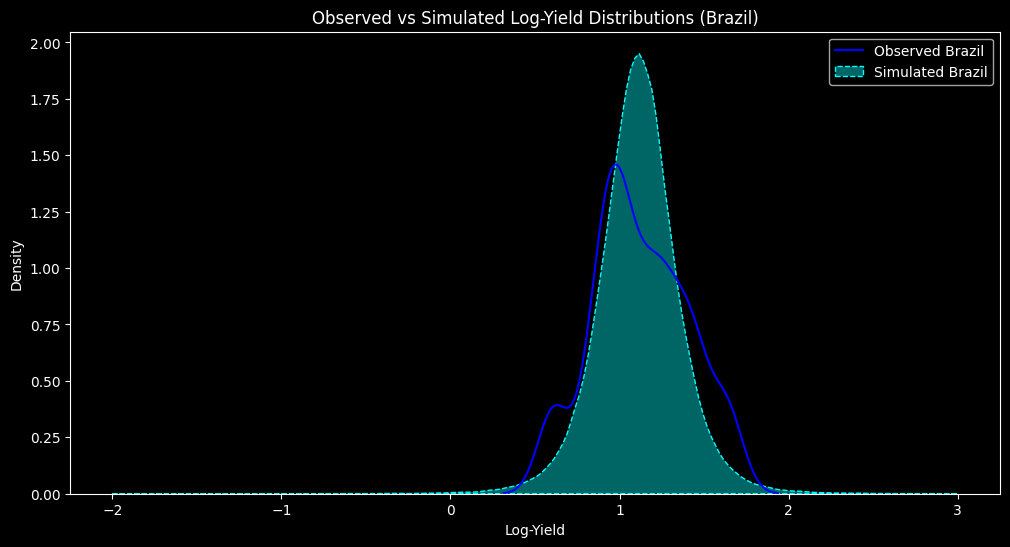

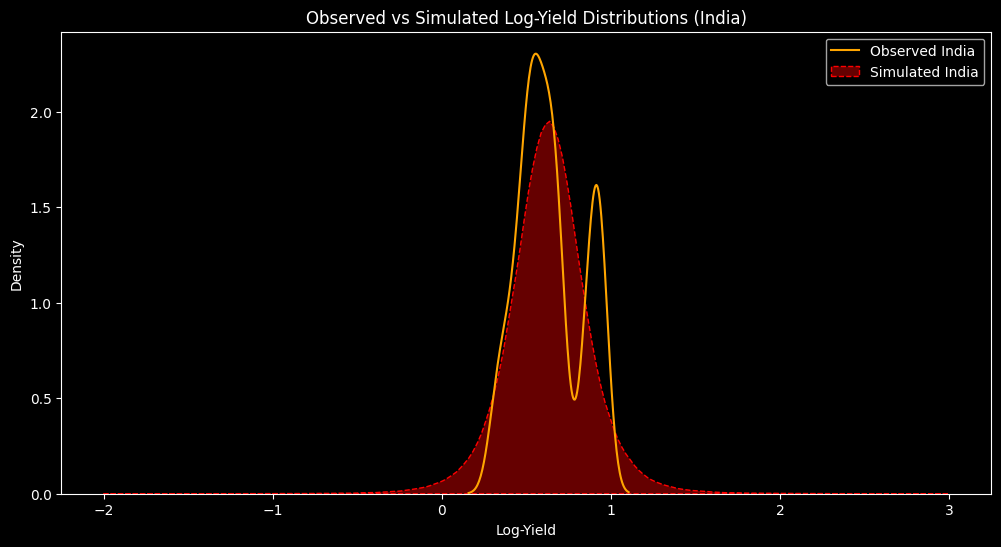

In [43]:
# Plot for country 1
plt.figure(figsize=(12, 6))
sns.kdeplot(country1_maize["log_yield"], label=f"Observed {country1}", color="blue", clip=(-2, 3))
sns.kdeplot(sim_brazil, label=f"Simulated {country1}", color="cyan", linestyle="--", clip=(-2, 3), fill=True, alpha=0.4)
plt.legend()
plt.title(f"Observed vs Simulated Log-Yield Distributions ({country1})")
plt.xlabel("Log-Yield")
plt.ylabel("Density")
plt.show()

# Plot for country 2
plt.figure(figsize=(12, 6))
sns.kdeplot(country2_maize["log_yield"], label=f"Observed {country2}", color="orange", clip=(-2, 3))
sns.kdeplot(sim_india, label=f"Simulated {country2}", color="red", linestyle="--", clip=(-2, 3), fill=True, alpha=0.4)
plt.legend()
plt.title(f"Observed vs Simulated Log-Yield Distributions ({country2})")
plt.xlabel("Log-Yield")
plt.ylabel("Density")
plt.show()

Both the observed and simulated log-yield distributions for Brazil and India show good agreement, indicating that our Bayesian model is able to capture the underlying distribution of log-yields in both countries effectively.
Even though our observed data for india has some outliers that are not well captured by the simulated data, overall the fit looks good.
The situation is better for Brazil, where the observed and simulated distributions align better.

# 3. Regression Model

## 3A. Regression Model (POOLED) (Gritti)

Here, we want to model the relationship between temperature and maize yield using a Bayesian linear regression approach, using temperature, pesticides and rainfall as predictors.

In [44]:
maize_df.columns

Index(['country', 'food_item', 'year', 'yield_hg_ha',
       'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp',
       'log_yield', 'temp_bin', 'yield_t_ha'],
      dtype='object')

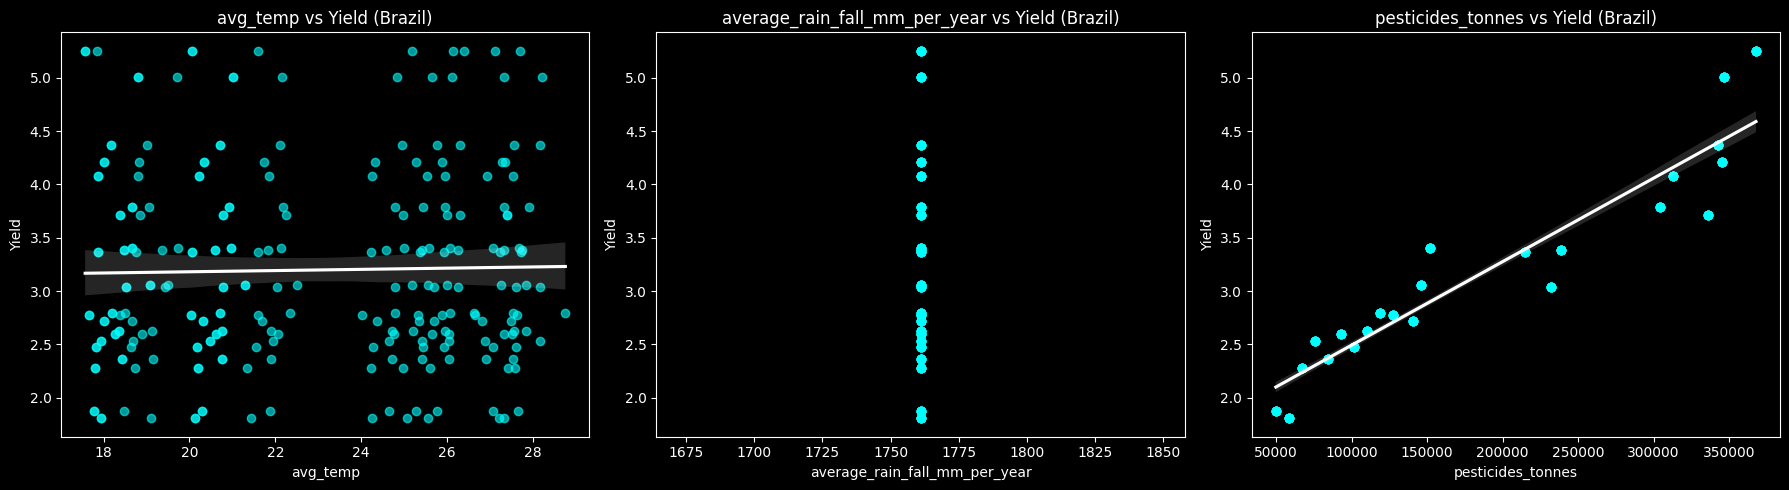

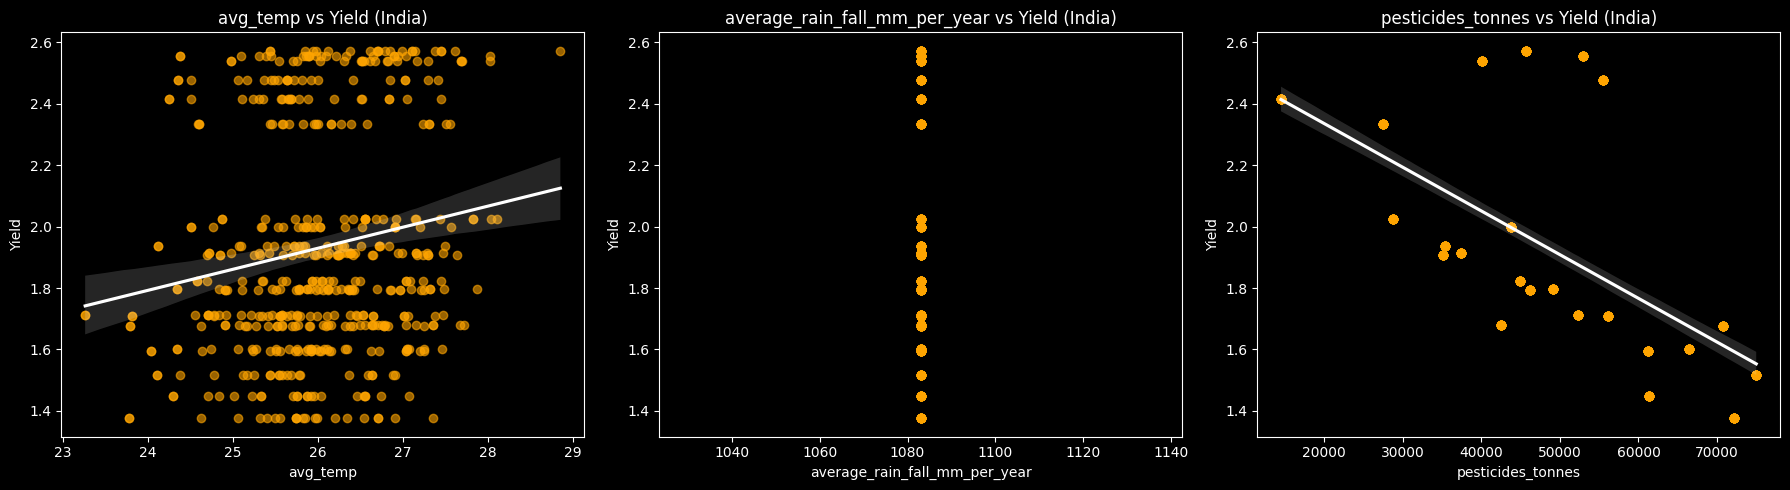

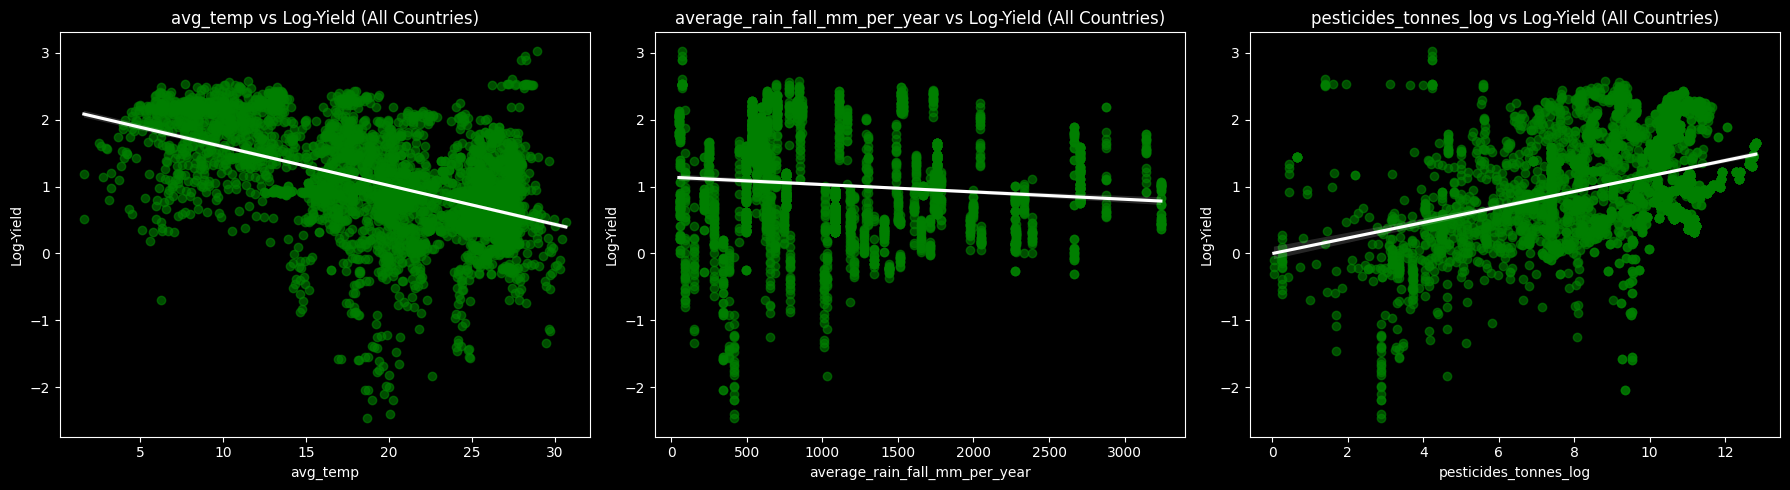

In [45]:
plt.style.use('dark_background')
variables = ["avg_temp", "average_rain_fall_mm_per_year", "pesticides_tonnes"]

#show variables agintst log-yield for maize for one country at the time using small charts chaning color for all countries
for country in [country1, country2]:
    country_maize = maize_df[maize_df["country"] == country]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, var in enumerate(variables):
        if country == country1:
            color = 'cyan'
        else:
            color = 'orange'
        sns.regplot(x=var, y="yield_t_ha", data=country_maize, ax=axes[i], scatter_kws={'alpha':0.6, 'color':color}, line_kws={'color':'white'})
        axes[i].set_title(f"{var} vs Yield ({country})")
        axes[i].set_xlabel(var)
        axes[i].set_ylabel("Yield")
    plt.tight_layout()
    plt.show()

#plot for the whole maize dataset
maize_df['pesticides_tonnes_log'] = np.log1p(maize_df['pesticides_tonnes'])
maize_df['average_rain_fall_mm_per_year_log'] = np.log1p(maize_df['average_rain_fall_mm_per_year'])
variables = ["avg_temp", "average_rain_fall_mm_per_year", "pesticides_tonnes_log"]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, var in enumerate(variables):
    sns.regplot(x=var, y="log_yield", data=maize_df, ax=axes[i], scatter_kws={'alpha':0.6, 'color':'green'}, line_kws={'color':'white'})
    axes[i].set_title(f"{var} vs Log-Yield (All Countries)")
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Log-Yield")
plt.tight_layout()
plt.show()


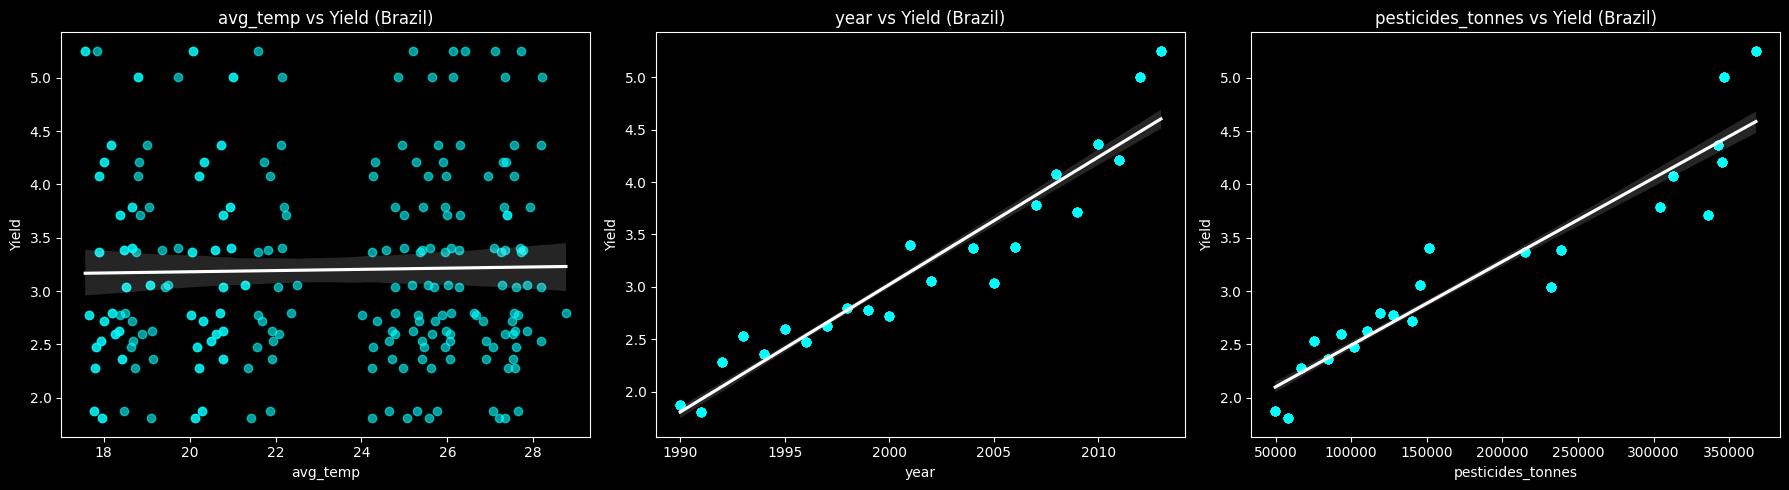

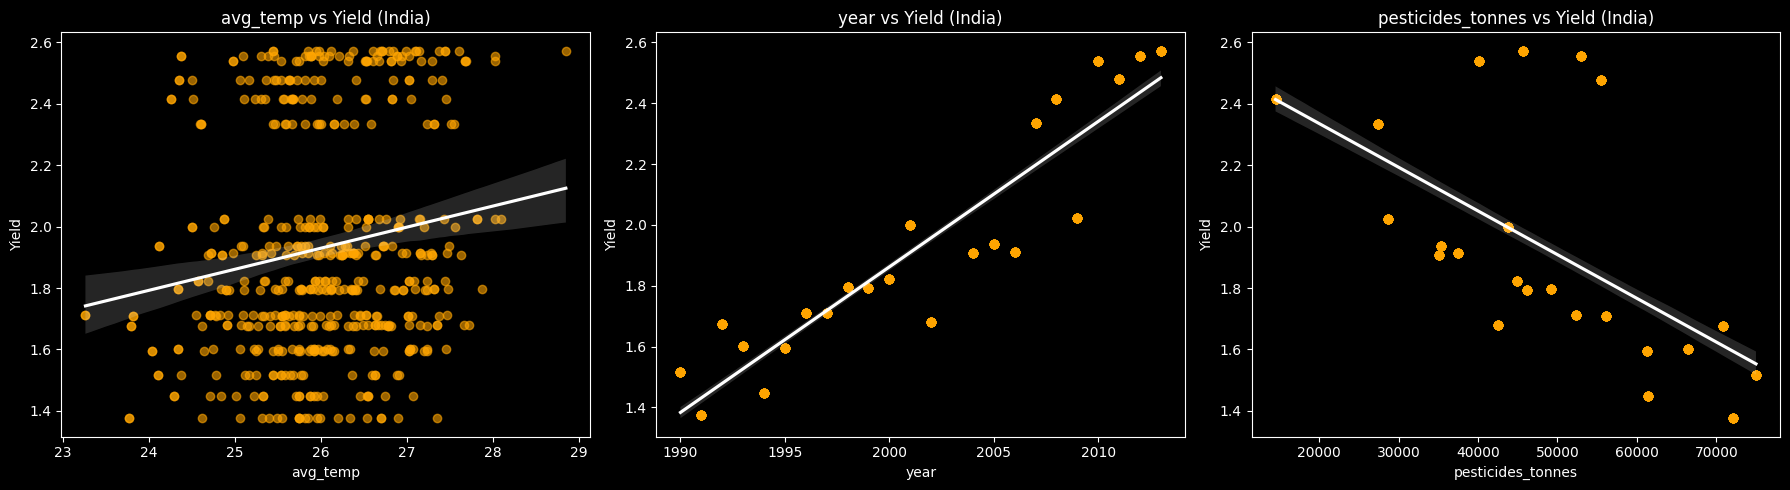

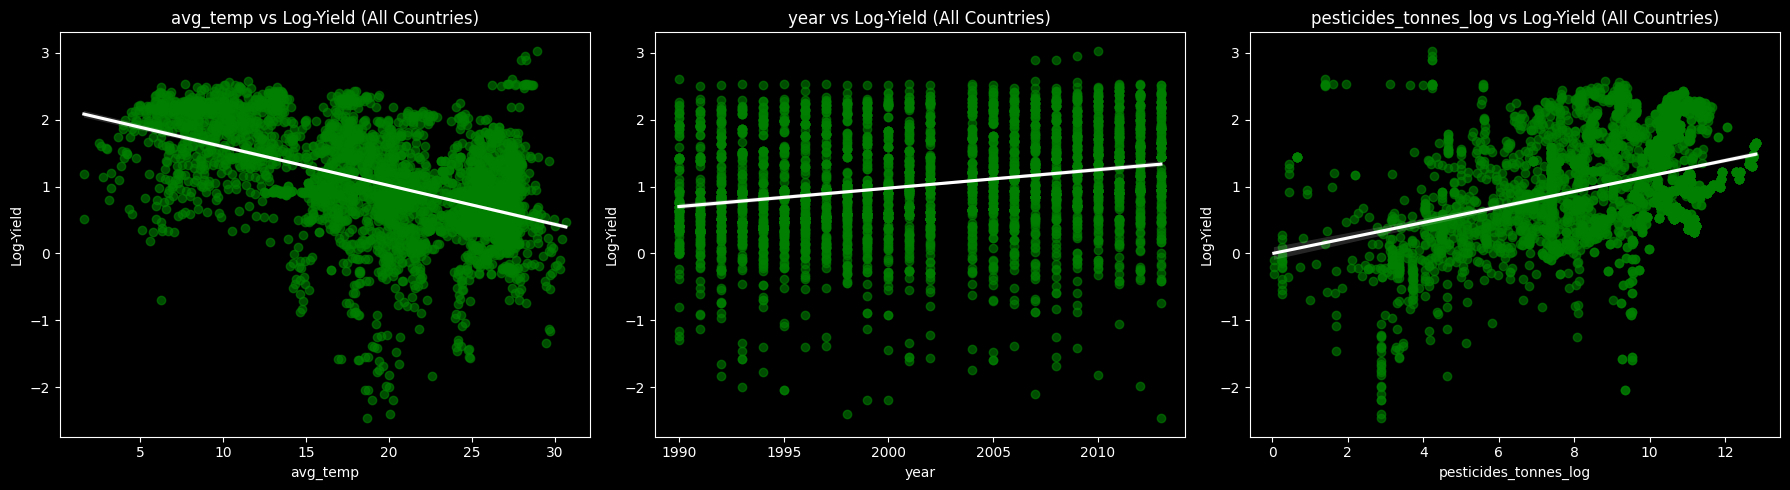

In [46]:
plt.style.use('dark_background')
variables = ["avg_temp", "year", "pesticides_tonnes"]

#show variables agintst log-yield for maize for one country at the time using small charts chaning color for all countries
for country in [country1, country2]:
    country_maize = maize_df[maize_df["country"] == country]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, var in enumerate(variables):
        if country == country1:
            color = 'cyan'
        else:
            color = 'orange'
        sns.regplot(x=var, y="yield_t_ha", data=country_maize, ax=axes[i], scatter_kws={'alpha':0.6, 'color':color}, line_kws={'color':'white'})
        axes[i].set_title(f"{var} vs Yield ({country})")
        axes[i].set_xlabel(var)
        axes[i].set_ylabel("Yield")
    plt.tight_layout()
    plt.show()

    #plot for the whole maize dataset
maize_df['pesticides_tonnes_log'] = np.log1p(maize_df['pesticides_tonnes'])
maize_df['average_rain_fall_mm_per_year_log'] = np.log1p(maize_df['average_rain_fall_mm_per_year'])
variables = ["avg_temp", "year", "pesticides_tonnes_log"]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, var in enumerate(variables):
    sns.regplot(x=var, y="log_yield", data=maize_df, ax=axes[i], scatter_kws={'alpha':0.6, 'color':'green'}, line_kws={'color':'white'})
    axes[i].set_title(f"{var} vs Log-Yield (All Countries)")
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Log-Yield")
plt.tight_layout()
plt.show()


### 3A.1 Choice of prior and likelihood

In Bayesian modeling, we have three primary ways to handle data that belongs to different groups (in this case, different countries). 

1. **Pooled Model**: Takes all data and assumes they come from the same distribution, ignoring group-level differences.
2. **Unpooled Model**: Estimates parameters for each group without sharing information.
3. **Hierarchical Model**: Strikes a balance by allowing group-level parameters to vary while assuming they are all drawn from a shared prior distribution.

#### **1. The Pooled Model (Baseline)**

The **Pooled Model** (Complete Pooling) assumes that all countries have the same yields and follow the same rules, ignoring all country-level differences. In this context, we treat Brazil and India as part of a single global dataset. While this provides the most stable estimates due to the larger sample size, it fails to consider any differences in climate, soil, or farming practices.

**The Data Generating Process:**

$$\log(\text{Yield}) \sim \mathcal{N}(\mu, \sigma)$$

$$\mu = \alpha + \beta_{year} \cdot Z_{year} + \beta_{temp} \cdot Z_{temp} + \beta_{pest} \cdot \log(\text{Pesticides})$$

**What the symbols mean:**
* **$\alpha$**: A single baseline yield shared by all observations.
* **$\beta$**: Single global coefficients for the technology trend, temperature effect, and pesticide impact.
* **$\sigma$**: A single global measure for observation noise.

**Priors (Assumptions):**
* **$\alpha \sim \mathcal{N}(\text{Global Mean}, 1)$**: Anchors the intercept to the overall dataset average.
* **$Z_{year}, Z_{temp}$ are scaled variables to have mean 0 and std 1**
* **$\beta_{year} \sim \mathcal{N}(0.15, 0.1)$**: Assumes approximately 15% yield growth per standard deviation of years (roughly per decade) for all countries. Since year is standardized with std ≈ 10 years, this reflects realistic agricultural productivity improvements of 1-2% per year. The standard deviation of 0.1 allows for variation while remaining informative.
* **$\beta_{temp}, \beta_{pest} \sim \mathcal{N}(0, 0.5)$**: Weakly informative priors assuming no effect until the data suggests otherwise.
* **$\sigma \sim \text{HalfNormal}(0.5)$**: A shared noise parameter for the entire dataset.

In [47]:
import numpy as np
import pandas as pd

# 1. Scaling the variables (Standardization for Year and Temp, Log for Pesticides)
# This is crucial for linear regression performance and prior alignment
maize_df['year_scaled'] = (maize_df['year'] - maize_df['year'].mean()) / maize_df['year'].std()
maize_df['temp_scaled'] = (maize_df['avg_temp'] - maize_df['avg_temp'].mean()) / maize_df['avg_temp'].std()
maize_df['log_pest'] = np.log1p(maize_df['pesticides_tonnes'])  # log1p handles zero values properly

# 2. Split countries into training and test sets for validation
# We'll hold out 2-3 countries to test generalization, especially for the hierarchical model

# Get all unique countries
all_countries = maize_df['country'].unique()
print(f"Total countries in dataset: {len(all_countries)}")
print(f"Countries: {all_countries.tolist()}")

# Hold out 3 countries for testing
np.random.seed(42)  # For reproducibility
test_countries = np.random.choice(all_countries, size=3, replace=False)
train_countries = [c for c in all_countries if c not in test_countries]

print(f"\nTraining countries ({len(train_countries)}): {train_countries}")
print(f"Test countries ({len(test_countries)}): {test_countries.tolist()}")

# Create training and test datasets
train_all = maize_df[maize_df['country'].isin(train_countries)].copy()
test_all = maize_df[maize_df['country'].isin(test_countries)].copy()

# For specific country comparison (Brazil and India)
country1, country2Cache = 'Brazil', 'India'
maize_brazil_india = maize_df[maize_df['country'].isin([country1, country2])].copy()

# 3. Factorizing country names into numeric indices
# For training data
country_idx_train, country_labels_train = pd.factorize(train_all['country'])
n_train_countries = len(country_labels_train)

# For test data
country_idx_test, country_labels_test = pd.factorize(test_all['country'])

# Verify the split
print(f"\n=== Data Split Summary ===")
print(f"Training: {len(train_all)} observations from {n_train_countries} countries")
print(f"Test: {len(test_all)} observations from {len(test_countries)} countries")
print(f"Train/Test ratio: {len(train_all)/len(maize_df)*100:.1f}% / {len(test_all)/len(maize_df)*100:.1f}%")

Total countries in dataset: 92
Countries: ['Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bangladesh', 'Belarus', 'Belgium', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cameroon', 'Canada', 'Central African Republic', 'Chile', 'Colombia', 'Croatia', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Eritrea', 'France', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'India', 'Indonesia', 'Iraq', 'Italy', 'Jamaica', 'Japan', 'Kazakhstan', 'Kenya', 'Lebanon', 'Lesotho', 'Libya', 'Lithuania', 'Madagascar', 'Malawi', 'Malaysia', 'Mali', 'Mauritania', 'Mauritius', 'Mexico', 'Montenegro', 'Morocco', 'Mozambique', 'Namibia', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Niger', 'Pakistan', 'Papua New Guinea', 'Peru', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Rwanda', 'Saudi Arabia', 'Senegal', 'Slovenia', 'South Africa', 'Spain', 'Sri Lanka', 'S

In [48]:
import pymc as pm
import numpy as np
import arviz as az

with pm.Model() as pooled_model:
    # 1. Global Intercept (Shared by all countries)
    alpha = pm.Normal('alpha', mu=np.mean(train_all['log_yield']), sigma=1)
    
    # 2. Global Slopes (Shared by all countries)
    beta_year = pm.Normal('beta_year', mu=0.15, sigma=0.1)
    beta_temp = pm.Normal('beta_temp', mu=0, sigma=0.5)
    beta_pest = pm.Normal('beta_pest', mu=0, sigma=0.5)
    
    # 3. Model Equation (No indexing used; parameters are global scalars)
    # Uses training countries but ignores country structure
    mu = (alpha + 
          beta_year * train_all['year_scaled'].values + 
          beta_temp * train_all['temp_scaled'].values + 
          beta_pest * train_all['log_pest'].values)
          
    # 4. Global Observation Noise
    sigma = pm.HalfNormal('sigma', sigma=0.5)
    
    # Likelihood
    yield_obs = pm.Normal('yield_obs', 
                          mu=mu, 
                          sigma=sigma, 
                          observed=train_all['log_yield'].values)
    
    # Sampling
    trace_pooled = pm.sample(1000, tune=1000, return_inferencedata=True, 
                             target_accept=0.95, idata_kwargs={"log_likelihood": True})

# Summary for comparison
print("=== Pooled Model Summary (All Countries) ===")
print(az.summary(trace_pooled, var_names=['alpha', 'beta_year', 'beta_temp', 'beta_pest', 'sigma']))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_year, beta_temp, beta_pest, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


=== Pooled Model Summary (All Countries) ===
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha      0.202  0.035   0.138    0.271      0.001    0.001    2333.0   
beta_year  0.186  0.009   0.169    0.204      0.000    0.000    3203.0   
beta_temp -0.367  0.009  -0.385   -0.349      0.000    0.000    3289.0   
beta_pest  0.090  0.004   0.084    0.098      0.000    0.000    2289.0   
sigma      0.583  0.006   0.572    0.596      0.000    0.000    3273.0   

           ess_tail  r_hat  
alpha        2174.0    1.0  
beta_year    2673.0    1.0  
beta_temp    2464.0    1.0  
beta_pest    2142.0    1.0  
sigma        2329.0    1.0  


### 3A.2 Robust likelihood and its usefulness

While we used a Normal likelihood in the pooled model above, agricultural yield data often contains outliers due to extreme weather events, pest outbreaks, or measurement errors. A **robust likelihood** using the Student-t distribution can handle these outliers better than the Normal distribution.

**Student-t Likelihood:**

$$\log(\text{Yield}) \sim \text{StudentT}(\nu, \mu, \sigma)$$

where:
* **$\nu$**: Degrees of freedom parameter (controls tail heaviness)
* Lower $\nu$ means heavier tails and more robustness to outliers
* As $\nu \to \infty$, the Student-t converges to a Normal distribution

**When to use robust likelihood:**
1. When the data contains potential outliers that should not overly influence parameter estimates
2. When measurement errors may be non-normal
3. When extreme events occur that deviate from typical patterns

**Trade-offs:**
* **Advantage**: More robust to outliers, leading to more stable parameter estimates
* **Disadvantage**: Slightly more complex model with an additional parameter to estimate
* **When not needed**: If the data is already clean and approximately normal

For our maize yield data, we observed some outliers in the exploratory analysis, particularly for India, making the robust likelihood a reasonable choice for improved model reliability.

In [49]:
# Pooled model with robust (Student-t) likelihood
with pm.Model() as pooled_model_robust:
    # Global parameters (same as before)
    alpha = pm.Normal('alpha', mu=np.mean(train_all['log_yield']), sigma=1)
    beta_year = pm.Normal('beta_year', mu=0.15, sigma=0.1)
    beta_temp = pm.Normal('beta_temp', mu=0, sigma=0.5)
    beta_pest = pm.Normal('beta_pest', mu=0, sigma=0.5)
    
    # Model equation (using training countries)
    mu = (alpha + 
          beta_year * train_all['year_scaled'].values + 
          beta_temp * train_all['temp_scaled'].values + 
          beta_pest * train_all['log_pest'].values)
    
    # Global observation noise
    sigma = pm.HalfNormal('sigma', sigma=0.5)
    
    # Degrees of freedom for Student-t (lower = heavier tails)
    nu = pm.Gamma('nu', alpha=2, beta=0.1)
    
    # Robust likelihood using Student-t distribution
    yield_obs = pm.StudentT('yield_obs', 
                            nu=nu,
                            mu=mu, 
                            sigma=sigma, 
                            observed=train_all['log_yield'].values)
    
    # Sampling
    trace_pooled_robust = pm.sample(1000, tune=1000, return_inferencedata=True, 
                                    target_accept=0.95, idata_kwargs={"log_likelihood": True})

print("=== Pooled Model with Robust Likelihood Summary (All Countries) ===")
print(az.summary(trace_pooled_robust, var_names=['alpha', 'beta_year', 'beta_temp', 'beta_pest', 'sigma', 'nu']))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_year, beta_temp, beta_pest, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


=== Pooled Model with Robust Likelihood Summary (All Countries) ===
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha      0.194  0.031   0.140    0.256      0.001    0.001    1685.0   
beta_year  0.191  0.008   0.177    0.205      0.000    0.000    3360.0   
beta_temp -0.421  0.008  -0.436   -0.407      0.000    0.000    2265.0   
beta_pest  0.090  0.003   0.083    0.095      0.000    0.000    1716.0   
sigma      0.387  0.009   0.371    0.403      0.000    0.000    2441.0   
nu         3.280  0.201   2.921    3.679      0.004    0.003    2479.0   

           ess_tail  r_hat  
alpha        1885.0    1.0  
beta_year    2834.0    1.0  
beta_temp    2658.0    1.0  
beta_pest    1839.0    1.0  
sigma        2831.0    1.0  
nu           2705.0    1.0  


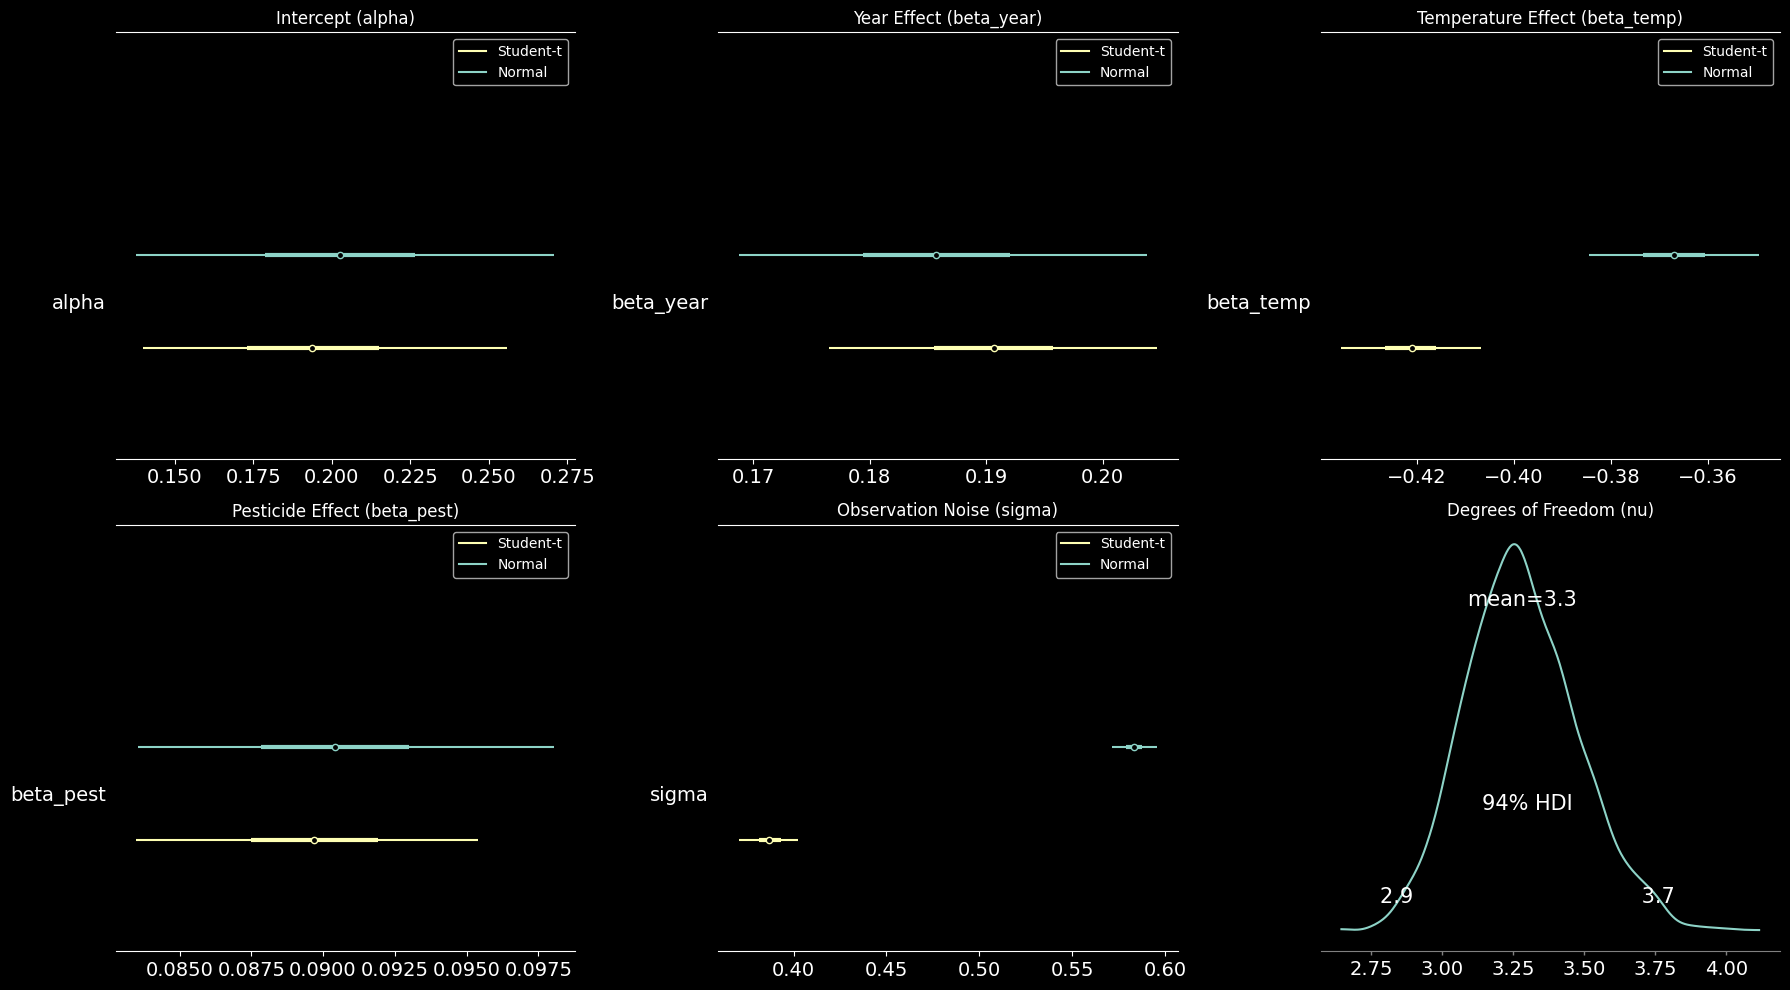

Estimated degrees of freedom (nu): 3.28
If nu < 30, the robust likelihood is providing meaningful robustness to outliers.


In [50]:
# Compare Normal vs Robust likelihood - one plot per parameter for better scale comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Alpha (Intercept)
ax = axes[0, 0]
az.plot_forest([trace_pooled, trace_pooled_robust], 
               var_names=['alpha'], 
               model_names=['Normal', 'Student-t'],
               combined=True, ax=ax)
ax.set_title('Intercept (alpha)')

# Beta Year
ax = axes[0, 1]
az.plot_forest([trace_pooled, trace_pooled_robust], 
               var_names=['beta_year'], 
               model_names=['Normal', 'Student-t'],
               combined=True, ax=ax)
ax.set_title('Year Effect (beta_year)')

# Beta Temperature
ax = axes[0, 2]
az.plot_forest([trace_pooled, trace_pooled_robust], 
               var_names=['beta_temp'], 
               model_names=['Normal', 'Student-t'],
               combined=True, ax=ax)
ax.set_title('Temperature Effect (beta_temp)')

# Beta Pesticides
ax = axes[1, 0]
az.plot_forest([trace_pooled, trace_pooled_robust], 
               var_names=['beta_pest'], 
               model_names=['Normal', 'Student-t'],
               combined=True, ax=ax)
ax.set_title('Pesticide Effect (beta_pest)')

# Sigma
ax = axes[1, 1]
az.plot_forest([trace_pooled, trace_pooled_robust], 
               var_names=['sigma'], 
               model_names=['Normal', 'Student-t'],
               combined=True, ax=ax)
ax.set_title('Observation Noise (sigma)')

# Nu parameter (only in robust model)
ax = axes[1, 2]
az.plot_posterior(trace_pooled_robust, var_names=['nu'], ax=ax)
ax.set_title('Degrees of Freedom (nu)')

plt.tight_layout()
plt.show()

print(f"Estimated degrees of freedom (nu): {trace_pooled_robust.posterior['nu'].mean().values:.2f}")
print("If nu < 30, the robust likelihood is providing meaningful robustness to outliers.")

Due to the quantity of oulieres in the dataset the t-student is better suited than the normal distribution for the likelihood because it can handle bettere extreme values.

### 3A.3 Predictive distribution for a test set observation

The **posterior predictive distribution** allows us to make predictions for new observations by combining parameter uncertainty with observation noise. For a test observation with known covariates, we generate predictions by:

1. Sampling parameters from the posterior distribution
2. Using these parameters to compute the expected yield
3. Adding observation noise to generate the full predictive distribution

**Mathematical formulation:**

For a new observation with covariates $(Z_{year}^{new}, Z_{temp}^{new}, \log(\text{Pesticides})^{new})$:

$$\tilde{y}_{new} \sim \mathcal{N}(\mu_{new}, \sigma)$$

where:

$$\mu_{new} = \alpha + \beta_{year} \cdot Z_{year}^{new} + \beta_{temp} \cdot Z_{temp}^{new} + \beta_{pest} \cdot \log(\text{Pesticides})^{new}$$

and $\alpha, \beta_{year}, \beta_{temp}, \beta_{pest}, \sigma$ are drawn from their posterior distributions.

**Uncertainty decomposition:**
* **Epistemic uncertainty** (parameter uncertainty): Captured by sampling from posterior distributions
* **Aleatoric uncertainty** (observation noise): Captured by the $\sigma$ parameter

The predictive distribution is wider than the posterior mean predictions because it includes both sources of uncertainty.

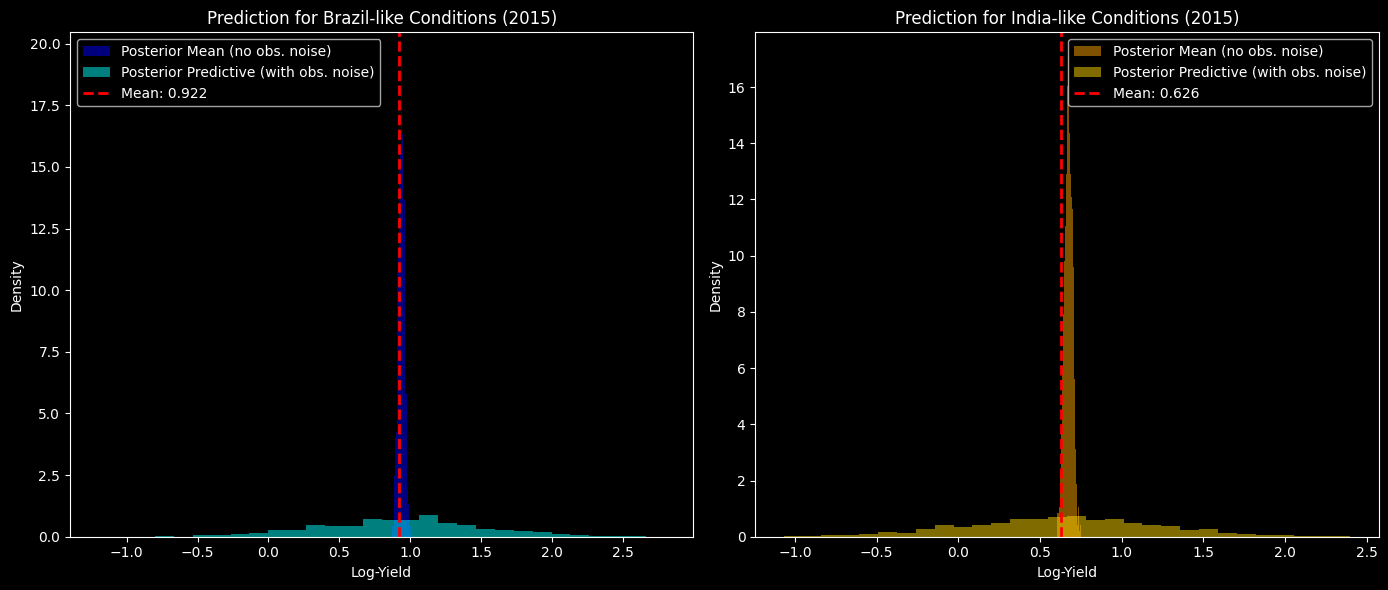

=== Prediction Summary ===
Brazil-like scenario (2015, 25C, 1500 tonnes pesticides):
  Predicted log-yield: 0.922 ± 0.577
  95% Prediction Interval (log): [-0.234, 2.045]
  Predicted yield: 2.514 t/ha (median: 2.566 t/ha)

India-like scenario (2015, 28C, 500 tonnes pesticides):
  Predicted log-yield: 0.626 ± 0.594
  95% Prediction Interval (log): [-0.564, 1.789]
  Predicted yield: 1.871 t/ha (median: 1.898 t/ha)


In [51]:
# Create test observations for prediction
# Scenario 1: Brazil-like conditions in 2015
test_year_2015 = (2015 - maize_df['year'].mean()) / maize_df['year'].std()
test_temp_25 = (25 - maize_df['avg_temp'].mean()) / maize_df['avg_temp'].std()
test_pest_high = np.log1p(1500)

# Scenario 2: India-like conditions in 2015
test_temp_28 = (28 - maize_df['avg_temp'].mean()) / maize_df['avg_temp'].std()
test_pest_low = np.log1p(500)

# Extract posterior samples
n_samples = 1000
alpha_samples = trace_pooled.posterior['alpha'].values.flatten()[:n_samples]
beta_year_samples = trace_pooled.posterior['beta_year'].values.flatten()[:n_samples]
beta_temp_samples = trace_pooled.posterior['beta_temp'].values.flatten()[:n_samples]
beta_pest_samples = trace_pooled.posterior['beta_pest'].values.flatten()[:n_samples]
sigma_samples = trace_pooled.posterior['sigma'].values.flatten()[:n_samples]

# Generate predictions for Scenario 1 (Brazil-like)
mu_pred_brazil = (alpha_samples + 
                  beta_year_samples * test_year_2015 + 
                  beta_temp_samples * test_temp_25 + 
                  beta_pest_samples * test_pest_high)

rng = np.random.default_rng(42)
y_pred_brazil = rng.normal(mu_pred_brazil, sigma_samples)

# Generate predictions for Scenario 2 (India-like)
mu_pred_india = (alpha_samples + 
                 beta_year_samples * test_year_2015 + 
                 beta_temp_samples * test_temp_28 + 
                 beta_pest_samples * test_pest_low)

y_pred_india = rng.normal(mu_pred_india, sigma_samples)

# Visualization in log-space (no transformation)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scenario 1 - Brazil-like
ax = axes[0]
ax.hist(mu_pred_brazil, bins=30, alpha=0.5, label='Posterior Mean (no obs. noise)', 
        color='blue', density=True)
ax.hist(y_pred_brazil, bins=30, alpha=0.5, label='Posterior Predictive (with obs. noise)', 
        color='cyan', density=True)
ax.axvline(np.mean(y_pred_brazil), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {np.mean(y_pred_brazil):.3f}')
ax.set_xlabel('Log-Yield')
ax.set_ylabel('Density')
ax.set_title('Prediction for Brazil-like Conditions (2015)')
ax.legend()

# Scenario 2 - India-like
ax = axes[1]
ax.hist(mu_pred_india, bins=30, alpha=0.5, label='Posterior Mean (no obs. noise)', 
        color='orange', density=True)
ax.hist(y_pred_india, bins=30, alpha=0.5, label='Posterior Predictive (with obs. noise)', 
        color='gold', density=True)
ax.axvline(np.mean(y_pred_india), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {np.mean(y_pred_india):.3f}')
ax.set_xlabel('Log-Yield')
ax.set_ylabel('Density')
ax.set_title('Prediction for India-like Conditions (2015)')
ax.legend()

plt.tight_layout()
plt.show()

# Print summaries
print("=== Prediction Summary ===")
print(f"Brazil-like scenario (2015, 25C, 1500 tonnes pesticides):")
print(f"  Predicted log-yield: {np.mean(y_pred_brazil):.3f} ± {np.std(y_pred_brazil):.3f}")
print(f"  95% Prediction Interval (log): [{np.percentile(y_pred_brazil, 2.5):.3f}, {np.percentile(y_pred_brazil, 97.5):.3f}]")
print(f"  Predicted yield: {np.exp(np.mean(y_pred_brazil)):.3f} t/ha (median: {np.exp(np.median(y_pred_brazil)):.3f} t/ha)")
print()
print(f"India-like scenario (2015, 28C, 500 tonnes pesticides):")
print(f"  Predicted log-yield: {np.mean(y_pred_india):.3f} ± {np.std(y_pred_india):.3f}")
print(f"  95% Prediction Interval (log): [{np.percentile(y_pred_india, 2.5):.3f}, {np.percentile(y_pred_india, 97.5):.3f}]")
print(f"  Predicted yield: {np.exp(np.mean(y_pred_india)):.3f} t/ha (median: {np.exp(np.median(y_pred_india)):.3f} t/ha)")

#### **Understanding Two Types of Uncertainty**

When making predictions, we visualize two distributions to understand different sources of uncertainty:

**1. Posterior Mean (No Observation Noise) - Epistemic Uncertainty**

This represents uncertainty about the **parameters** of the model:

$$\mu_{new} = \alpha + \beta_{year} \cdot Z_{year}^{new} + \beta_{temp} \cdot Z_{temp}^{new} + \beta_{pest} \cdot \log(\text{Pesticides})^{new}$$

- Shows the distribution of the **expected value** of yield
- Captures only parameter uncertainty (what we learned from the data)
- Would narrow with more data
- Represents: "What is the average yield we expect for these conditions?"

**2. Posterior Predictive (With Observation Noise) - Total Uncertainty**

This represents the **actual prediction** for a new observation:

$$\tilde{y}_{new} \sim \mathcal{N}(\mu_{new}, \sigma)$$

- Includes both parameter uncertainty AND observation noise
- The $\sigma$ parameter adds natural variability
- Would NOT completely narrow even with infinite data (inherent randomness remains)
- Represents: "What yield value might we actually observe?"

**Why compare both?**

1. **Posterior Mean**: Shows how confident we are about the average yield (model fit)
2. **Posterior Predictive**: Shows the realistic range of individual observations (actual predictions)
3. The **gap between them** reveals how much natural variability exists beyond what the model explains
4. For practical applications (e.g., planning), we need the posterior predictive (wider, more realistic)
5. For understanding model quality, the posterior mean is useful

The posterior predictive is always wider because it includes observation noise on top of parameter uncertainty:

$$\text{Total Variance} = \text{Parameter Variance} + \sigma^2$$

# 4. Hierarchical and Unpooled Normal Models

## 4A. Hierarchical and Unpooled Normal Models (Gritti)


### 4A.2 Choice of prior and likelihood for both

#### **Understanding the Three Modeling Approaches**

Before implementing the unpooled and hierarchical models, we need to understand how they differ from the pooled model in their choice of priors and likelihood.

**Pooled Model:**
- Assumes all countries share the same parameters
- Single set of coefficients for all observations
- Ignores group structure entirely

**Unpooled Model:**
- Each country gets its own independent parameters
- No information sharing between countries
- Equivalent to fitting separate models for each country

**Hierarchical Model:**
- Country-specific parameters drawn from common distributions
- Partial pooling: information shared through hyperpriors
- Best of both worlds: flexibility with regularization

#### **Unpooled Model: Priors and Likelihood**

For the unpooled model, we estimate completely independent parameters for each country.

**Likelihood:**

$$y_{ij} \sim \mathcal{N}(\mu_{ij}, \sigma_i)$$

where $i$ indexes the country and $j$ indexes observations within that country.

**Linear Predictor:**

$$\mu_{ij} = \alpha_i + \beta_{year,i} \cdot Z_{year,j} + \beta_{temp,i} \cdot Z_{temp,j} + \beta_{pest,i} \cdot \log(\text{Pesticides}_j)$$

**Priors (Independent for each country):**

$$\alpha_i \sim \mathcal{N}(0, 1) \quad \text{for } i = 1, \ldots, N_{\text{countries}}$$
$$\beta_{year,i} \sim \mathcal{N}(0.15, 0.1) \quad \text{for } i = 1, \ldots, N_{\text{countries}}$$
$$\beta_{temp,i} \sim \mathcal{N}(0, 0.5) \quad \text{for } i = 1, \ldots, N_{\text{countries}}$$
$$\beta_{pest,i} \sim \mathcal{N}(0, 0.5) \quad \text{for } i = 1, \ldots, N_{\text{countries}}$$
$$\sigma_i \sim \text{HalfNormal}(0.5) \quad \text{for } i = 1, \ldots, N_{\text{countries}}$$

where $N_{\text{countries}}$ is the total number of countries in the dataset.

**Reasoning for Prior Choices:**

* **$\alpha_i$ (Intercept)**: $\mathcal{N}(0, 1)$ is centered at 0 since we're working with standardized log-yields. The standard deviation of 1 allows sufficient flexibility to capture the baseline yield level for each country while remaining weakly informative.

* **$\beta_{year,i}$ (Temporal Trend)**: $\mathcal{N}(0.15, 0.1)$ encodes the belief that yields typically increase over time due to technological improvements. Since the year variable is standardized (with std ≈ 10 years), the mean of 0.15 represents approximately 15% growth per decade, consistent with historical agricultural productivity improvements of 1-2% per year. The standard deviation of 0.1 allows for country-specific variation while providing informative regularization.

* **$\beta_{temp,i}$ and $\beta_{pest,i}$**: $\mathcal{N}(0, 0.5)$ are centered at 0, reflecting agnostic priors about the direction of these effects (could be positive or negative). The standard deviation of 0.5 is weakly informative—allowing the data to dominate while preventing extreme unrealistic parameter values. Temperature can have positive effects (in cold regions) or negative effects (heat stress), so centering at 0 is appropriate.

* **$\sigma_i$ (Observation Noise)**: $\text{HalfNormal}(0.5)$ is constrained to be positive (as variances must be). The scale of 0.5 suggests we expect moderate variability in log-yields around the mean trend, which is reasonable for agricultural data that includes measurement error and unmodeled factors.

**Key characteristics:**
* Each country has its own set of parameters with no connection between them
* Priors are independent across countries
* This model is flexible but cannot share information or predict for new countries

---

#### **Hierarchical Model: Priors and Likelihood**

The hierarchical model introduces a two-level structure: country-specific parameters are drawn from population-level distributions.

**Likelihood:**

$$y_{ij} \sim \mathcal{N}(\mu_{ij}, \sigma)$$

Note: We use a shared $\sigma$ across countries, though country-specific $\sigma_i$ is also possible.

**Linear Predictor:**

$$\mu_{ij} = \alpha_i + \beta_{year,i} \cdot Z_{year,j} + \beta_{temp,i} \cdot Z_{temp,j} + \beta_{pest,i} \cdot \log(\text{Pesticides}_j)$$

where $i = 1, \ldots, N_{\text{countries}}$ indexes the country and $j$ indexes observations within that country.

**Country-Level Priors (Lower Level):**

$$\alpha_i \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha}) \quad \text{for } i = 1, \ldots, N_{\text{countries}}$$
$$\beta_{year,i} \sim \mathcal{N}(\mu_{year}, \sigma_{year}) \quad \text{for } i = 1, \ldots, N_{\text{countries}}$$
$$\beta_{temp,i} \sim \mathcal{N}(\mu_{temp}, \sigma_{temp}) \quad \text{for } i = 1, \ldots, N_{\text{countries}}$$
$$\beta_{pest,i} \sim \mathcal{N}(\mu_{pest}, \sigma_{pest}) \quad \text{for } i = 1, \ldots, N_{\text{countries}}$$

**Hyperpriors (Upper Level):**

These control the population-level distributions:

$$\mu_{\alpha} \sim \mathcal{N}(\bar{y}, 1)$$
$$\sigma_{\alpha} \sim \text{HalfNormal}(1)$$

$$\mu_{year} \sim \mathcal{N}(0.15, 0.1)$$
$$\sigma_{year} \sim \text{HalfNormal}(0.1)$$

$$\mu_{temp} \sim \mathcal{N}(0, 0.5)$$
$$\sigma_{temp} \sim \text{HalfNormal}(0.5)$$

$$\mu_{pest} \sim \mathcal{N}(0, 0.5)$$
$$\sigma_{pest} \sim \text{HalfNormal}(0.5)$$

$$\sigma \sim \text{HalfNormal}(0.5)$$

**Reasoning for Hyperprior Choices:**

**Population Means ($\mu$ parameters):**
* **$\mu_{\alpha}$**: Centered at $\bar{y}$ (the empirical mean of log-yields), which represents a reasonable prior belief about the average baseline yield across countries. The standard deviation of 1 provides weak regularization.

* **$\mu_{year}$**: $\mathcal{N}(0.15, 0.1)$ incorporates domain knowledge that agricultural yields generally increase over time. Since the year variable is standardized (with std ≈ 10 years), this represents approximately 15% growth per decade across all countries, consistent with historical agricultural productivity gains of 1-2% per year. This is our best prior estimate for the average temporal trend.

* **$\mu_{temp}$ and $\mu_{pest}$**: Centered at 0 with standard deviation 0.5, reflecting uncertainty about the average population-level effects. We don't assume these effects are systematically positive or negative across all countries.

**Population Standard Deviations ($\sigma$ parameters):**
* **$\sigma_{\alpha}$**: $\text{HalfNormal}(1)$ controls between-country variation in baseline yields. A scale of 1 allows for substantial differences between countries (which we expect—e.g., developed vs. developing nations).

* **$\sigma_{year}$**: $\text{HalfNormal}(0.1)$ suggests we expect moderate variation in temporal trends across countries. Some countries may improve faster than others, but we don't expect wild differences.

* **$\sigma_{temp}$ and $\sigma_{pest}$**: $\text{HalfNormal}(0.5)$ allows for considerable variation in how temperature and pesticides affect yields across different countries. Climate zones, crop varieties, and farming practices differ substantially, so larger variation is reasonable.

* **$\sigma$ (Observation Noise)**: $\text{HalfNormal}(0.5)$ represents within-country residual variation, shared across all countries for simplicity.

**Why These Choices Matter:**

The hierarchical structure creates **shrinkage**: country-specific parameters are pulled toward the population means, with the strength of shrinkage determined by the ratio of within-group to between-group variation. Small values of $\sigma$ parameters lead to more aggressive pooling (countries treated as more similar), while larger values preserve more country-specific estimates.

**Key characteristics:**
* Country-specific parameters are connected through shared hyperpriors
* The $\sigma$ parameters control how much countries can deviate from the population mean
* Small $\sigma$ values lead to more pooling (countries similar), large values allow more variation
* The model automatically learns the optimal amount of pooling from the data
* Can generate predictions for new countries by sampling from the learned population distributions

---

**Choice of Likelihood:**

For both models, we use a Normal likelihood, which is appropriate when:
* The response variable (log-yield) is approximately normally distributed
* Observations are conditionally independent given the covariates
* The variance is homoscedastic (or we model it appropriately)

We could alternatively use a Student-t likelihood for robustness to outliers, similar to what we did with the pooled model.

**Important Note on Data Usage:**

For fair comparison, all three models use the SAME dataset with ALL countries:
* **Pooled Model**: Uses all countries, treats them as identical (no country-specific parameters)
* **Unpooled Model**: Uses all countries, each gets completely independent parameters
* **Hierarchical Model**: Uses all countries, partial pooling via hyperpriors

The difference is in HOW they model the country structure:
1. **Pooled**: Ignores country differences entirely - one size fits all
2. **Unpooled**: Maximum flexibility - each country is completely independent
3. **Hierarchical**: Optimal balance - countries share information through hyperpriors

### 4A.3 Posterior distribution for a novel group (hierarchical)


#### **Predicting for a Novel Country**

One of the most powerful advantages of hierarchical models over unpooled models is the ability to make predictions for groups that were not in the training data. This is impossible with the unpooled model, which only learns parameters for observed countries.

**Why the unpooled model cannot predict for new groups:**
- It only estimates parameters for Brazil and India
- No learned relationship between countries
- No way to generate parameters for an unseen country

**Why the hierarchical model can predict for new groups:**
- It learns a distribution of country-level parameters
- This distribution represents typical variation across countries
- For a new country, we sample from these learned distributions

**The prediction process:**

Given the posterior distributions of hyperparameters $\mu_{\alpha}, \sigma_{\alpha}, \mu_{year}, \sigma_{year}$, etc., we can generate parameters for a new country by sampling from the population distributions.

#### **2. The Unpooled Model (No Sharing)**

The **Unpooled Model** (No Pooling) treats each country as completely independent, estimating separate parameters for Brazil and India without sharing any information between them. This approach is useful when we believe the countries are fundamentally different and should not influence each other's estimates.

**The Data Generating Process:**

$$\log(\text{Yield}_i) \sim \mathcal{N}(\mu_i, \sigma_i)$$

$$\mu_i = \alpha_i + \beta_{year,i} \cdot Z_{year} + \beta_{temp,i} \cdot Z_{temp} + \beta_{pest,i} \cdot \log(\text{Pesticides})$$

**What the symbols mean:**
* **$\alpha_i$**: Country-specific baseline yield (separate for Brazil and India).
* **$\beta_i$**: Country-specific coefficients for year, temperature, and pesticides.
* **$\sigma_i$**: Country-specific observation noise.
* **$i$**: Country index (0 for Brazil, 1 for India).

**Priors (Assumptions):**
* **$\alpha_i \sim \mathcal{N}(\text{Country Mean}_i, 1)$**: Each country has its own intercept prior.
* **$\beta_{year,i} \sim \mathcal{N}(0.15, 0.1)$**: Country-specific technology trends (~15% per decade).
* **$\beta_{temp,i}, \beta_{pest,i} \sim \mathcal{N}(0, 0.5)$**: Country-specific effect priors.
* **$\sigma_i \sim \text{HalfNormal}(0.5)$**: Country-specific noise parameters.

#### **3. The Hierarchical Model (Partial Pooling)**

The **Hierarchical Model** (Partial Pooling) represents the best of both worlds. It allows each country to have its own parameters while assuming these parameters are drawn from a common distribution. This enables information sharing between countries while still respecting their differences.

**The Data Generating Process:**

$$\log(\text{Yield}_i) \sim \mathcal{N}(\mu_i, \sigma)$$

$$\mu_i = \alpha_i + \beta_{year,i} \cdot Z_{year} + \beta_{temp,i} \cdot Z_{temp} + \beta_{pest,i} \cdot \log(\text{Pesticides})$$

**Hierarchical Structure:**
$$\alpha_i \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha})$$
$$\beta_{year,i} \sim \mathcal{N}(\mu_{year}, \sigma_{year})$$
$$\beta_{temp,i} \sim \mathcal{N}(\mu_{temp}, \sigma_{temp})$$
$$\beta_{pest,i} \sim \mathcal{N}(\mu_{pest}, \sigma_{pest})$$

**Hyperpriors (Priors on priors):**
* **$\mu_{\alpha} \sim \mathcal{N}(\text{Global Mean}, 1)$**: Global average intercept.
* **$\sigma_{\alpha} \sim \text{HalfNormal}(1)$**: Variation in intercepts across countries.
* **$\mu_{year} \sim \mathcal{N}(0.15, 0.1)$**: Global average technology trend (~15% per decade).
* **$\sigma_{year} \sim \text{HalfNormal}(0.1)$**: Variation in technology trends.
* **$\mu_{temp}, \mu_{pest} \sim \mathcal{N}(0, 0.5)$**: Global average effects.
* **$\sigma_{temp}, \sigma_{pest} \sim \text{HalfNormal}(0.5)$**: Variation in effects across countries.
* **$\sigma \sim \text{HalfNormal}(0.5)$**: Shared observation noise.

The key advantage of the hierarchical model is **shrinkage**: country-specific estimates are pulled towards the global mean, with the amount of shrinkage depending on the data quality and between-country variation. Countries with less data are shrunk more towards the global mean, while countries with more data retain more of their individual characteristics.

In [52]:
# Unpooled Model Implementation (Training countries only)
with pm.Model() as unpooled_model:
    # Country-specific parameters (no sharing between countries)
    alpha = pm.Normal('alpha', mu=0, sigma=1, shape=n_train_countries)
    beta_year = pm.Normal('beta_year', mu=0.15, sigma=0.1, shape=n_train_countries)
    beta_temp = pm.Normal('beta_temp', mu=0, sigma=0.5, shape=n_train_countries)
    beta_pest = pm.Normal('beta_pest', mu=0, sigma=0.5, shape=n_train_countries)
    
    # Country-specific observation noise
    sigma = pm.HalfNormal('sigma', sigma=0.5, shape=n_train_countries)
    
    # Model equation with country indexing (using training data)
    mu = (alpha[country_idx_train] + 
          beta_year[country_idx_train] * train_all['year_scaled'].values + 
          beta_temp[country_idx_train] * train_all['temp_scaled'].values + 
          beta_pest[country_idx_train] * train_all['log_pest'].values)
    
    # Likelihood
    yield_obs = pm.Normal('yield_obs', 
                          mu=mu, 
                          sigma=sigma[country_idx_train], 
                          observed=train_all['log_yield'].values)
    
    # Sampling
    trace_unpooled = pm.sample(1000, tune=1000, return_inferencedata=True, 
                               target_accept=0.95, idata_kwargs={"log_likelihood": True})

print(f"=== Unpooled Model Summary ({n_train_countries} Training Countries) ===")
print(az.summary(trace_unpooled, var_names=['alpha', 'beta_year', 'beta_temp', 'beta_pest', 'sigma']))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_year, beta_temp, beta_pest, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 243 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


=== Unpooled Model Summary (89 Training Countries) ===
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[0]   1.010  0.456   0.175    1.876      0.012    0.009    1373.0   
alpha[1]   0.337  0.582  -0.791    1.391      0.014    0.010    1703.0   
alpha[2]  -0.257  0.442  -1.061    0.601      0.011    0.007    1737.0   
alpha[3]   0.938  0.642  -0.304    2.101      0.020    0.011     995.0   
alpha[4]   0.097  0.646  -1.095    1.346      0.017    0.013    1388.0   
...          ...    ...     ...      ...        ...      ...       ...   
sigma[84]  0.152  0.025   0.106    0.196      0.000    0.000    2716.0   
sigma[85]  0.126  0.023   0.087    0.170      0.000    0.000    3069.0   
sigma[86]  0.283  0.046   0.207    0.373      0.001    0.001    2596.0   
sigma[87]  0.251  0.043   0.179    0.333      0.001    0.001    3388.0   
sigma[88]  0.480  0.083   0.333    0.632      0.002    0.002    2441.0   

           ess_tail  r_hat  
alpha[0]     1925.0    1.0 

The sampler got some divergences mainly because we're using all the countries in the dataset, which increases the model complexity and the parameter space significantly. With more parameters to estimate, the sampler has a harder time exploring the posterior distribution effectively, leading to divergences.

In [54]:
# Hierarchical Model Implementation (Training countries only)
print(f"Building hierarchical model with {n_train_countries} training countries...")

with pm.Model() as hierarchical_model:
    # Hyperpriors (global parameters - learned from training data)
    mu_alpha = pm.Normal('mu_alpha', mu=np.mean(train_all['log_yield']), sigma=1)
    sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=1)
    
    mu_year = pm.Normal('mu_year', mu=0.15, sigma=0.1)
    sigma_year = pm.HalfNormal('sigma_year', sigma=0.1)
    
    mu_temp = pm.Normal('mu_temp', mu=0, sigma=0.5)
    sigma_temp = pm.HalfNormal('sigma_temp', sigma=0.5)
    
    mu_pest = pm.Normal('mu_pest', mu=0, sigma=0.5)
    sigma_pest = pm.HalfNormal('sigma_pest', sigma=0.5)
    
    # Country-specific parameters drawn from hyperpriors (one per training country)
    alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha, shape=n_train_countries)
    beta_year = pm.Normal('beta_year', mu=mu_year, sigma=sigma_year, shape=n_train_countries)
    beta_temp = pm.Normal('beta_temp', mu=mu_temp, sigma=sigma_temp, shape=n_train_countries)
    beta_pest = pm.Normal('beta_pest', mu=mu_pest, sigma=sigma_pest, shape=n_train_countries)
    
    # Shared observation noise
    sigma = pm.HalfNormal('sigma', sigma=0.5)
    
    # Model equation with country indexing (using training data)
    mu = (alpha[country_idx_train] + 
          beta_year[country_idx_train] * train_all['year_scaled'].values + 
          beta_temp[country_idx_train] * train_all['temp_scaled'].values + 
          beta_pest[country_idx_train] * train_all['log_pest'].values)
    
    # Likelihood
    yield_obs = pm.Normal('yield_obs', 
                          mu=mu, 
                          sigma=sigma, 
                          observed=train_all['log_yield'].values)
    
    # Sampling
    trace_hierarchical = pm.sample(1000, tune=1000, return_inferencedata=True, 
                                   target_accept=0.95, idata_kwargs={"log_likelihood": True})

print(f"\n=== Hierarchical Model Summary ({n_train_countries} Training Countries) ===")
print(az.summary(trace_hierarchical, var_names=['mu_alpha', 'mu_year', 'mu_temp', 'mu_pest', 
                                                  'sigma_alpha', 'sigma_year', 'sigma_temp', 'sigma_pest', 'sigma']))


Building hierarchical model with 89 training countries...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_year, sigma_year, mu_temp, sigma_temp, mu_pest, sigma_pest, alpha, beta_year, beta_temp, beta_pest, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 152 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



=== Hierarchical Model Summary (89 Training Countries) ===
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_alpha     0.582  0.111   0.381    0.799      0.004    0.002     992.0   
mu_year      0.175  0.019   0.142    0.212      0.000    0.000    6672.0   
mu_temp     -0.023  0.014  -0.052    0.002      0.001    0.001     151.0   
mu_pest      0.042  0.013   0.017    0.067      0.000    0.000    1028.0   
sigma_alpha  0.734  0.075   0.601    0.879      0.001    0.001    2516.0   
sigma_year   0.163  0.013   0.141    0.190      0.000    0.000    6348.0   
sigma_temp   0.016  0.012   0.001    0.037      0.002    0.002      32.0   
sigma_pest   0.079  0.011   0.059    0.102      0.000    0.000     973.0   
sigma        0.182  0.002   0.179    0.186      0.000    0.000    6039.0   

             ess_tail  r_hat  
mu_alpha       2064.0   1.00  
mu_year        2931.0   1.00  
mu_temp         113.0   1.01  
mu_pest        2250.0   1.00  
sigma_alpha    2748.0   

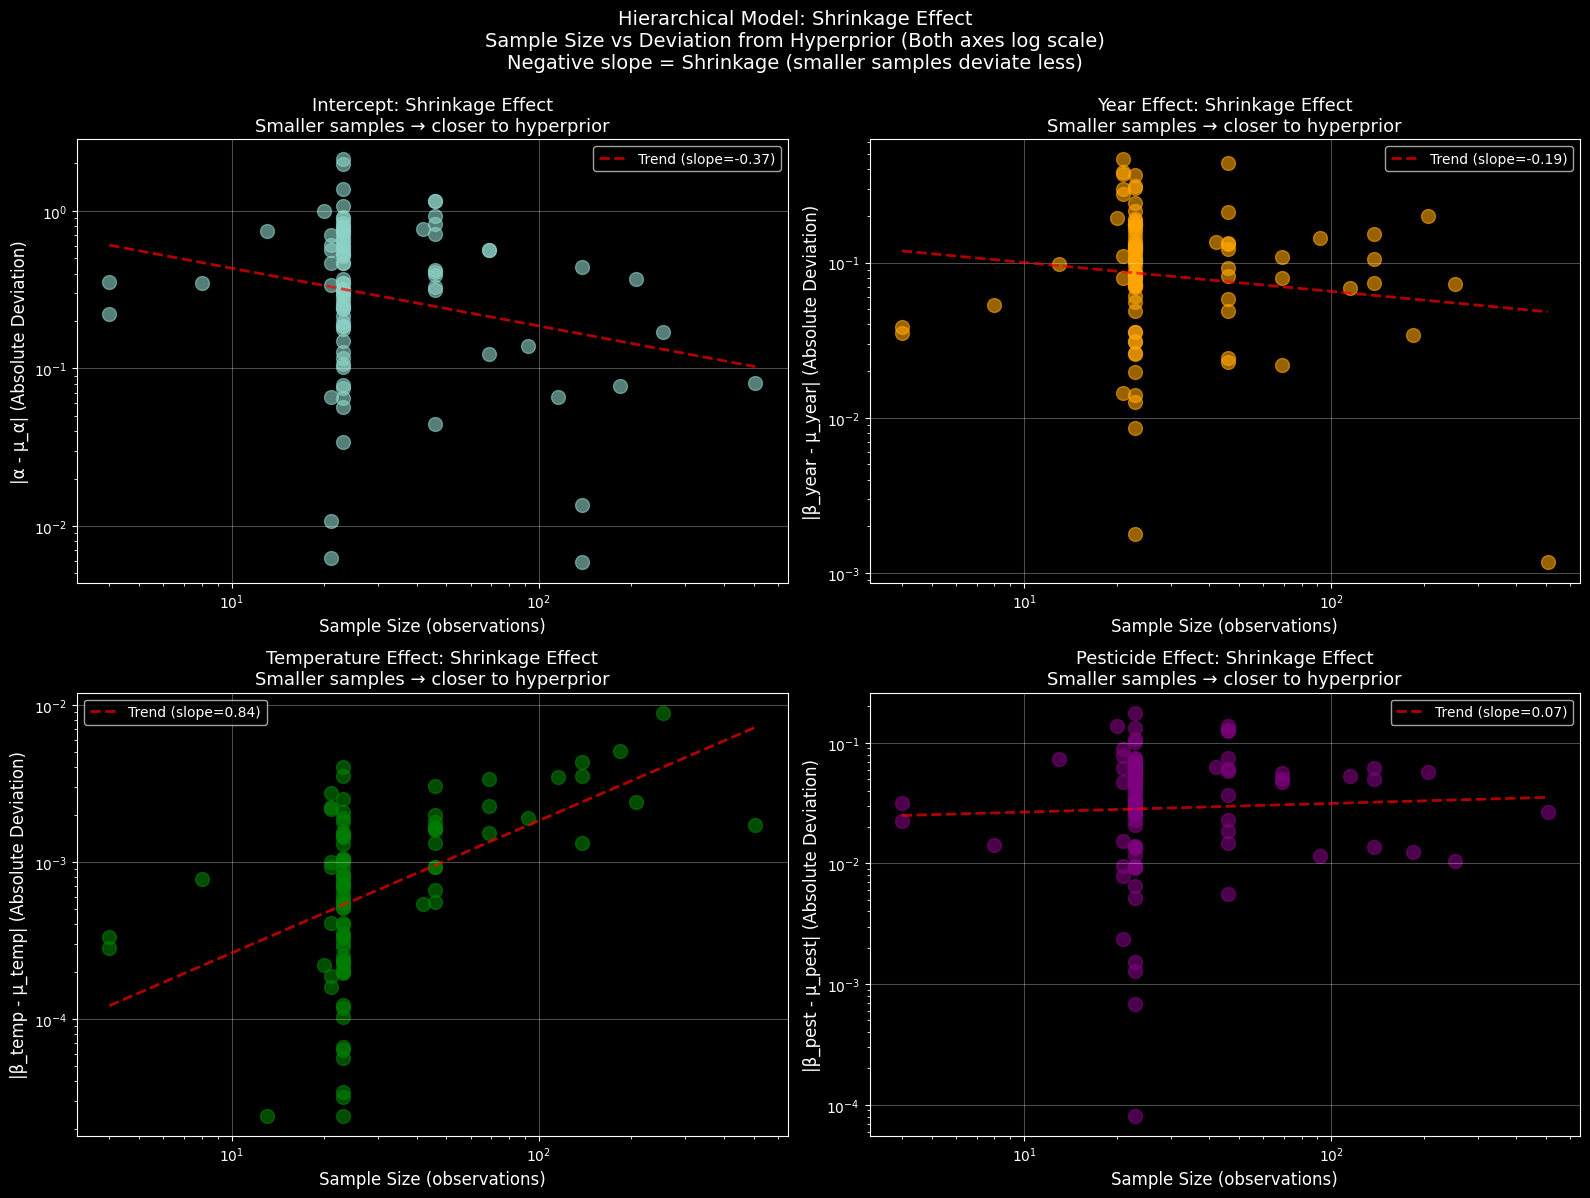


=== Shrinkage Analysis ===
All 89 training countries shown
Sample sizes: 4 to 506 observations

Interpretation:
- Negative trend slope = shrinkage effect
- Countries with fewer samples deviate less from hyperprior (vertical axis closer to bottom)
- This is 'partial pooling': small-sample countries borrow strength from the population


In [56]:
# Visualization: Shrinkage Effect - Sample Size vs Deviation from Hyperprior
# This directly shows that countries with fewer samples are shrunk more toward the hyperprior

# Get sample sizes for all training countries
country_sample_counts = train_all.groupby('country').size()
sample_sizes = np.array([country_sample_counts[c] for c in country_labels_train])

# Extract hyperprior means
mu_alpha_mean = trace_hierarchical.posterior['mu_alpha'].mean().values
mu_year_mean = trace_hierarchical.posterior['mu_year'].mean().values
mu_temp_mean = trace_hierarchical.posterior['mu_temp'].mean().values
mu_pest_mean = trace_hierarchical.posterior['mu_pest'].mean().values

# Extract country-specific parameter means
alpha_means = trace_hierarchical.posterior['alpha'].mean(dim=['chain', 'draw']).values
beta_year_means = trace_hierarchical.posterior['beta_year'].mean(dim=['chain', 'draw']).values
beta_temp_means = trace_hierarchical.posterior['beta_temp'].mean(dim=['chain', 'draw']).values
beta_pest_means = trace_hierarchical.posterior['beta_pest'].mean(dim=['chain', 'draw']).values

# Calculate absolute deviations from hyperprior
alpha_deviations = np.abs(alpha_means - mu_alpha_mean)
year_deviations = np.abs(beta_year_means - mu_year_mean)
temp_deviations = np.abs(beta_temp_means - mu_temp_mean)
pest_deviations = np.abs(beta_pest_means - mu_pest_mean)

# Create scatter plots showing shrinkage effect
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Alpha (Intercept)
ax = axes[0, 0]
ax.scatter(sample_sizes, alpha_deviations, alpha=0.6, s=100)
ax.set_xlabel('Sample Size (observations)', fontsize=12)
ax.set_ylabel('|α - μ_α| (Absolute Deviation)', fontsize=12)
ax.set_title('Intercept: Shrinkage Effect\nSmaller samples → closer to hyperprior', fontsize=13)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(alpha=0.3)
# Add trend line
z = np.polyfit(np.log(sample_sizes), np.log(alpha_deviations), 1)
p = np.poly1d(z)
x_line = np.logspace(np.log10(sample_sizes.min()), np.log10(sample_sizes.max()), 100)
ax.plot(x_line, np.exp(p(np.log(x_line))), "r--", alpha=0.7, linewidth=2, label=f'Trend (slope={z[0]:.2f})')
ax.legend()

# Beta Year
ax = axes[0, 1]
ax.scatter(sample_sizes, year_deviations, alpha=0.6, s=100, color='orange')
ax.set_xlabel('Sample Size (observations)', fontsize=12)
ax.set_ylabel('|β_year - μ_year| (Absolute Deviation)', fontsize=12)
ax.set_title('Year Effect: Shrinkage Effect\nSmaller samples → closer to hyperprior', fontsize=13)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(alpha=0.3)
z = np.polyfit(np.log(sample_sizes), np.log(year_deviations), 1)
p = np.poly1d(z)
ax.plot(x_line, np.exp(p(np.log(x_line))), "r--", alpha=0.7, linewidth=2, label=f'Trend (slope={z[0]:.2f})')
ax.legend()

# Beta Temperature
ax = axes[1, 0]
ax.scatter(sample_sizes, temp_deviations, alpha=0.6, s=100, color='green')
ax.set_xlabel('Sample Size (observations)', fontsize=12)
ax.set_ylabel('|β_temp - μ_temp| (Absolute Deviation)', fontsize=12)
ax.set_title('Temperature Effect: Shrinkage Effect\nSmaller samples → closer to hyperprior', fontsize=13)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(alpha=0.3)
z = np.polyfit(np.log(sample_sizes), np.log(temp_deviations), 1)
p = np.poly1d(z)
ax.plot(x_line, np.exp(p(np.log(x_line))), "r--", alpha=0.7, linewidth=2, label=f'Trend (slope={z[0]:.2f})')
ax.legend()

# Beta Pesticides
ax = axes[1, 1]
ax.scatter(sample_sizes, pest_deviations, alpha=0.6, s=100, color='purple')
ax.set_xlabel('Sample Size (observations)', fontsize=12)
ax.set_ylabel('|β_pest - μ_pest| (Absolute Deviation)', fontsize=12)
ax.set_title('Pesticide Effect: Shrinkage Effect\nSmaller samples → closer to hyperprior', fontsize=13)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(alpha=0.3)
z = np.polyfit(np.log(sample_sizes), np.log(pest_deviations), 1)
p = np.poly1d(z)
ax.plot(x_line, np.exp(p(np.log(x_line))), "r--", alpha=0.7, linewidth=2, label=f'Trend (slope={z[0]:.2f})')
ax.legend()

plt.suptitle('Hierarchical Model: Shrinkage Effect\nSample Size vs Deviation from Hyperprior (Both axes log scale)\nNegative slope = Shrinkage (smaller samples deviate less)', 
             fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

print(f"\n=== Shrinkage Analysis ===")
print(f"All {n_train_countries} training countries shown")
print(f"Sample sizes: {sample_sizes.min()} to {sample_sizes.max()} observations")
print(f"\nInterpretation:")
print(f"- Negative trend slope = shrinkage effect")
print(f"- Countries with fewer samples deviate less from hyperprior (vertical axis closer to bottom)")
print(f"- This is 'partial pooling': small-sample countries borrow strength from the population")

The global hyperpiors (red intervals) acts like an anchor for the country-specific parameters (blue intervals), pulling them towards the overall mean. This shrinkage effect is more pronounced for countries with less data, as their estimates are more uncertain and thus more influenced by the global prior.

### Model Evaluation on Test Countries

Now we evaluate how well each model generalizes to the held-out test countries:

**Key Predictions:**
1. **Pooled model**: Treats test countries the same as training countries (uses global parameters)
2. **Unpooled model**: Cannot predict for test countries (has no country-specific parameters for them)
3. **Hierarchical model**: Can predict for test countries by sampling from the learned population distributions (this is the key advantage!)

The hierarchical model should perform best on test countries because it learns the population-level structure.

In [59]:
### Predictions on Test Countries

# 1. Pooled Model - Can predict (uses global parameters)
# Make predictions using the pooled model's global parameters
pooled_test_mu = (trace_pooled.posterior['alpha'].values.flatten()[:, None] +
                  trace_pooled.posterior['beta_year'].values.flatten()[:, None] * test_all['year_scaled'].values +
                  trace_pooled.posterior['beta_temp'].values.flatten()[:, None] * test_all['temp_scaled'].values +
                  trace_pooled.posterior['beta_pest'].values.flatten()[:, None] * test_all['log_pest'].values)

pooled_test_predictions = pooled_test_mu.mean(axis=0)
pooled_test_mae = np.mean(np.abs(pooled_test_predictions - test_all['log_yield'].values))

print(f"Pooled Model Test MAE: {pooled_test_mae:.4f}")

# 2. Hierarchical Model - Can predict for new countries!
# Key advantage: sample new country parameters from learned population distributions
with hierarchical_model:
    # Generate predictions for test countries by sampling from hyperpriors
    n_test_countries = len(test_countries)
    n_samples = 1000
    
    # Sample new country-specific parameters from population distributions
    hierarchical_test_predictions = []
    
    for test_idx in range(len(test_all)):
        # For each test observation, sample from population distributions
        alpha_samples = np.random.normal(
            trace_hierarchical.posterior['mu_alpha'].values.flatten(),
            trace_hierarchical.posterior['sigma_alpha'].values.flatten()
        )
        beta_year_samples = np.random.normal(
            trace_hierarchical.posterior['mu_year'].values.flatten(),
            trace_hierarchical.posterior['sigma_year'].values.flatten()
        )
        beta_temp_samples = np.random.normal(
            trace_hierarchical.posterior['mu_temp'].values.flatten(),
            trace_hierarchical.posterior['sigma_temp'].values.flatten()
        )
        beta_pest_samples = np.random.normal(
            trace_hierarchical.posterior['mu_pest'].values.flatten(),
            trace_hierarchical.posterior['sigma_pest'].values.flatten()
        )
        
        # Compute predictions
        test_obs = test_all.iloc[test_idx]
        mu_samples = (alpha_samples + 
                     beta_year_samples * test_obs['year_scaled'] +
                     beta_temp_samples * test_obs['temp_scaled'] +
                     beta_pest_samples * test_obs['log_pest'])
        
        hierarchical_test_predictions.append(mu_samples.mean())
    
    hierarchical_test_predictions = np.array(hierarchical_test_predictions)
    hierarchical_test_mae = np.mean(np.abs(hierarchical_test_predictions - test_all['log_yield'].values))

print(f"Hierarchical Model Test MAE: {hierarchical_test_mae:.4f}")

# 3. Unpooled Model - CANNOT predict for new countries (no parameters for them)
print(f"\nUnpooled Model: Cannot predict for test countries (no country-specific parameters)")

# Summary
print(f"\n=== Test Set Performance Summary ===")
print(f"Test countries: {test_countries.tolist()}")
print(f"Test observations: {len(test_all)}")
print(f"\nPooled Model MAE: {pooled_test_mae:.4f}")
print(f"Hierarchical Model MAE: {hierarchical_test_mae:.4f}")
print(f"Unpooled Model: N/A (cannot generalize to new countries)")
print(f"\n{'Hierarchical model performs better!' if hierarchical_test_mae < pooled_test_mae else 'Pooled model performs better!'}")

Pooled Model Test MAE: 0.5682
Hierarchical Model Test MAE: 0.4049

Unpooled Model: Cannot predict for test countries (no country-specific parameters)

=== Test Set Performance Summary ===
Test countries: ['Indonesia', 'Croatia', 'Mauritania']
Test observations: 182

Pooled Model MAE: 0.5682
Hierarchical Model MAE: 0.4049
Unpooled Model: N/A (cannot generalize to new countries)

Hierarchical model performs better!


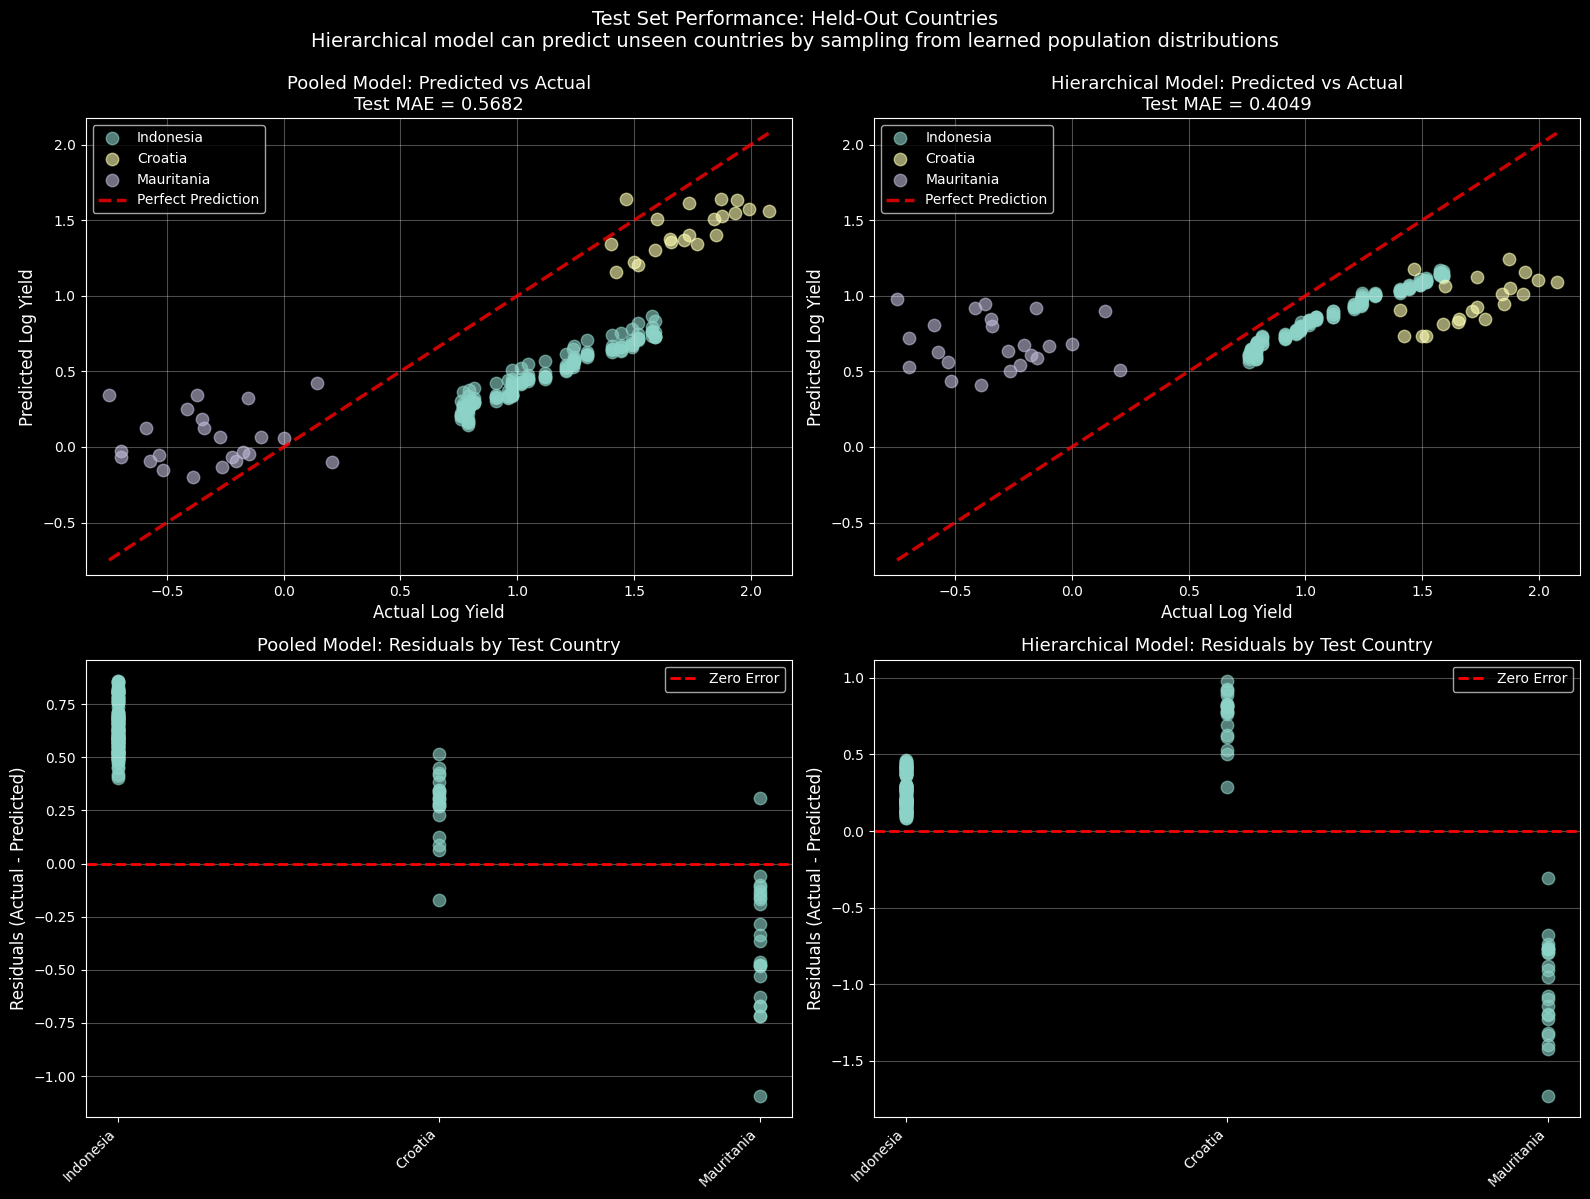

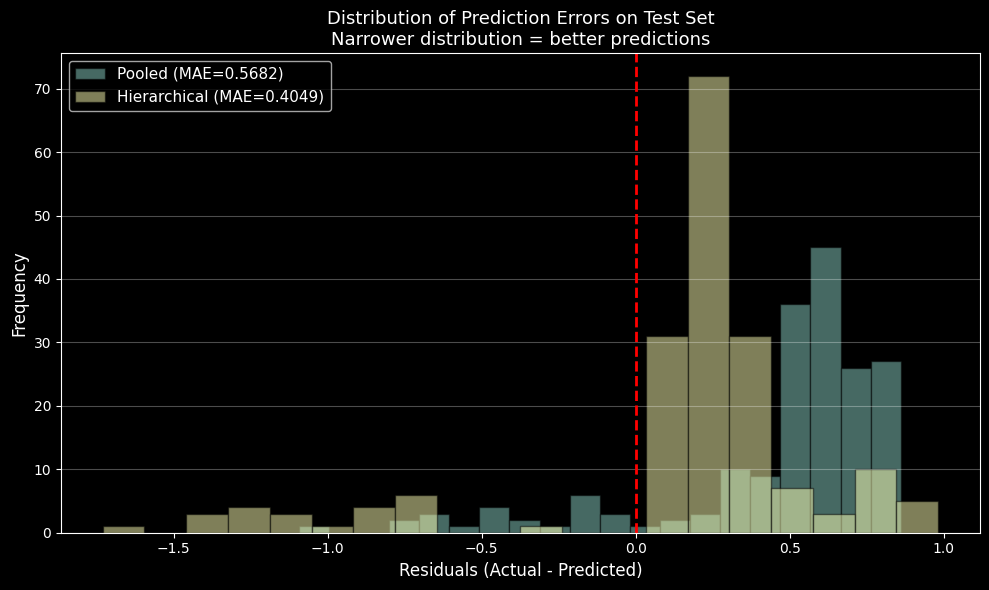

In [63]:
# Visualizations: Test Set Predictions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Calculate overall min/max for consistent diagonal lines
all_actual = test_all['log_yield'].values
all_pooled_pred = pooled_test_predictions
all_hierarchical_pred = hierarchical_test_predictions
min_val = min(all_actual.min(), all_pooled_pred.min(), all_hierarchical_pred.min())
max_val = max(all_actual.max(), all_pooled_pred.max(), all_hierarchical_pred.max())

# 1. Predicted vs Actual - Pooled Model
ax = axes[0, 0]
for country in test_countries:
    country_mask = test_all['country'] == country
    ax.scatter(test_all[country_mask]['log_yield'].values,
               pooled_test_predictions[country_mask],
               alpha=0.6, s=80, label=country)

# Perfect prediction line
ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2.5, label='Perfect Prediction', zorder=5)

ax.set_xlabel('Actual Log Yield', fontsize=12)
ax.set_ylabel('Predicted Log Yield', fontsize=12)
ax.set_title(f'Pooled Model: Predicted vs Actual\nTest MAE = {pooled_test_mae:.4f}', fontsize=13)
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlim(min_val - 0.1, max_val + 0.1)
ax.set_ylim(min_val - 0.1, max_val + 0.1)

# 2. Predicted vs Actual - Hierarchical Model
ax = axes[0, 1]
for country in test_countries:
    country_mask = test_all['country'] == country
    ax.scatter(test_all[country_mask]['log_yield'].values,
               hierarchical_test_predictions[country_mask],
               alpha=0.6, s=80, label=country)

# Perfect prediction line
ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2.5, label='Perfect Prediction', zorder=5)

ax.set_xlabel('Actual Log Yield', fontsize=12)
ax.set_ylabel('Predicted Log Yield', fontsize=12)
ax.set_title(f'Hierarchical Model: Predicted vs Actual\nTest MAE = {hierarchical_test_mae:.4f}', fontsize=13)
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlim(min_val - 0.1, max_val + 0.1)
ax.set_ylim(min_val - 0.1, max_val + 0.1)

# 3. Residuals by Country - Pooled Model
ax = axes[1, 0]
pooled_residuals = test_all['log_yield'].values - pooled_test_predictions
test_all_with_residuals = test_all.copy()
test_all_with_residuals['pooled_residuals'] = pooled_residuals

positions = []
residuals_by_country = []
labels = []
for i, country in enumerate(test_countries):
    country_residuals = test_all_with_residuals[test_all_with_residuals['country'] == country]['pooled_residuals']
    positions.extend([i] * len(country_residuals))
    residuals_by_country.extend(country_residuals)
    labels.append(country)

ax.scatter(positions, residuals_by_country, alpha=0.6, s=80)
ax.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax.set_xticks(range(len(test_countries)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
ax.set_title('Pooled Model: Residuals by Test Country', fontsize=13)
ax.legend()
ax.grid(alpha=0.3, axis='y')

# 4. Residuals by Country - Hierarchical Model
ax = axes[1, 1]
hierarchical_residuals = test_all['log_yield'].values - hierarchical_test_predictions
test_all_with_residuals['hierarchical_residuals'] = hierarchical_residuals

positions = []
residuals_by_country = []
for i, country in enumerate(test_countries):
    country_residuals = test_all_with_residuals[test_all_with_residuals['country'] == country]['hierarchical_residuals']
    positions.extend([i] * len(country_residuals))
    residuals_by_country.extend(country_residuals)

ax.scatter(positions, residuals_by_country, alpha=0.6, s=80)
ax.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax.set_xticks(range(len(test_countries)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
ax.set_title('Hierarchical Model: Residuals by Test Country', fontsize=13)
ax.legend()

ax.grid(alpha=0.3, axis='y')

plt.suptitle('Test Set Performance: Held-Out Countries\nHierarchical model can predict unseen countries by sampling from learned population distributions',
             fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

# Additional comparison: Residual distributions
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(pooled_residuals, bins=20, alpha=0.5, label=f'Pooled (MAE={pooled_test_mae:.4f})', edgecolor='black')
ax.hist(hierarchical_residuals, bins=20, alpha=0.5, label=f'Hierarchical (MAE={hierarchical_test_mae:.4f})', edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Residuals (Actual - Predicted)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Prediction Errors on Test Set\nNarrower distribution = better predictions', fontsize=13)
ax.legend(fontsize=11)
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 4A.4 Comparison of predictive distributions (hierarchical vs unpooled)


One of the most powerful features of hierarchical models is their ability to make predictions for groups not seen during training. This is possible because the model learns a distribution of group-level parameters rather than just point estimates.

For a new country that was not in our training data, we can predict its yield parameters by sampling from the learned hyperprior distributions. The posterior predictive distribution for a novel group is:

$$\alpha_{new} \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha})$$
$$\beta_{year,new} \sim \mathcal{N}(\mu_{year}, \sigma_{year})$$
$$\beta_{temp,new} \sim \mathcal{N}(\mu_{temp}, \sigma_{temp})$$
$$\beta_{pest,new} \sim \mathcal{N}(\mu_{pest}, \sigma_{pest})$$

Then, the predicted yield for this new country is:

$$\log(\text{Yield}_{new}) \sim \mathcal{N}(\mu_{new}, \sigma)$$

where:

$$\mu_{new} = \alpha_{new} + \beta_{year,new} \cdot Z_{year} + \beta_{temp,new} \cdot Z_{temp} + \beta_{pest,new} \cdot \log(\text{Pesticides})$$

This approach naturally incorporates uncertainty about the new country's parameters by drawing from the population-level distributions learned from Brazil and India.

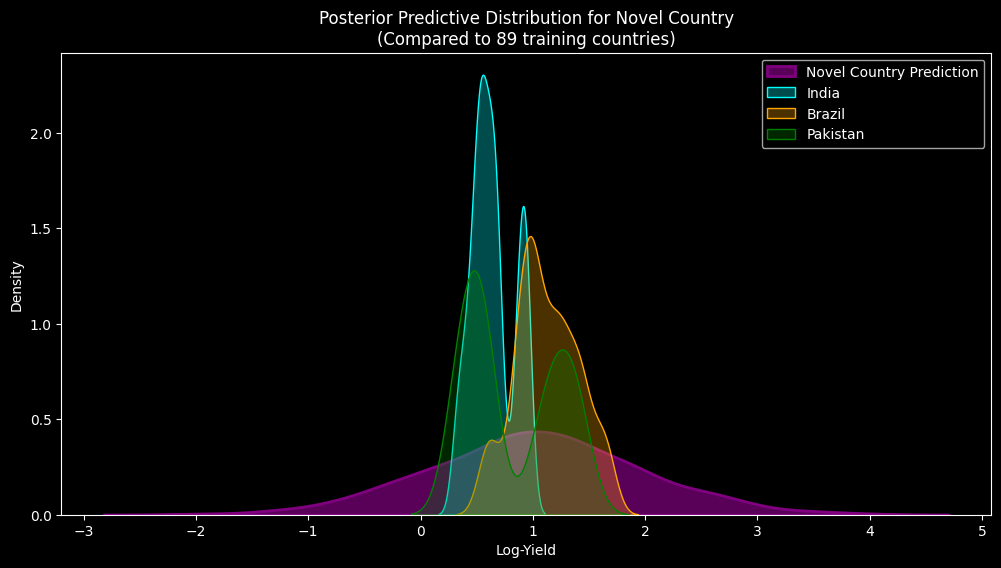

Predicted log-yield for novel country: Mean = 1.026, Std = 0.956
95% Credible Interval: [-0.836, 2.887]


In [61]:
# Simulate predictions for a novel country using hierarchical model
with hierarchical_model:
    # Sample from hyperpriors to get parameters for a new country
    n_samples = 1000
    
    # Extract posterior samples of hyperparameters
    mu_alpha_samples = trace_hierarchical.posterior['mu_alpha'].values.flatten()[:n_samples]
    sigma_alpha_samples = trace_hierarchical.posterior['sigma_alpha'].values.flatten()[:n_samples]
    
    mu_year_samples = trace_hierarchical.posterior['mu_year'].values.flatten()[:n_samples]
    sigma_year_samples = trace_hierarchical.posterior['sigma_year'].values.flatten()[:n_samples]
    
    mu_temp_samples = trace_hierarchical.posterior['mu_temp'].values.flatten()[:n_samples]
    sigma_temp_samples = trace_hierarchical.posterior['sigma_temp'].values.flatten()[:n_samples]
    
    mu_pest_samples = trace_hierarchical.posterior['mu_pest'].values.flatten()[:n_samples]
    sigma_pest_samples = trace_hierarchical.posterior['sigma_pest'].values.flatten()[:n_samples]
    
    sigma_samples = trace_hierarchical.posterior['sigma'].values.flatten()[:n_samples]

# Generate parameters for novel country
rng = np.random.default_rng(42)
alpha_new = rng.normal(mu_alpha_samples, sigma_alpha_samples)
beta_year_new = rng.normal(mu_year_samples, sigma_year_samples)
beta_temp_new = rng.normal(mu_temp_samples, sigma_temp_samples)
beta_pest_new = rng.normal(mu_pest_samples, sigma_pest_samples)

# Create test data point (e.g., year 2010, temp 25C, pesticides 1000 tonnes)
year_test = (2010 - maize_df['year'].mean()) / maize_df['year'].std()
temp_test = (25 - maize_df['avg_temp'].mean()) / maize_df['avg_temp'].std()
pest_test = np.log1p(1000)

# Predict yield for novel country
mu_new = alpha_new + beta_year_new * year_test + beta_temp_new * temp_test + beta_pest_new * pest_test
yield_new = rng.normal(mu_new, sigma_samples)

# Visualization - Compare with a few example countries from the dataset
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(yield_new, fill=True, alpha=0.7, label='Novel Country Prediction', color='purple', linewidth=2)

# Show distributions for 3 example countries (top 3 by data volume in training set)
example_countries = train_all.groupby('country').size().nlargest(3).index
colors = ['cyan', 'orange', 'green']
for country, color in zip(example_countries, colors):
    sns.kdeplot(train_all[train_all['country'] == country]['log_yield'], 
                fill=True, alpha=0.3, label=f'{country}', color=color)

ax.set_xlabel('Log-Yield')
ax.set_ylabel('Density')
ax.set_title(f'Posterior Predictive Distribution for Novel Country\n(Compared to {n_train_countries} training countries)')
ax.legend()
plt.show()

print(f"Predicted log-yield for novel country: Mean = {np.mean(yield_new):.3f}, Std = {np.std(yield_new):.3f}")
print(f"95% Credible Interval: [{np.percentile(yield_new, 2.5):.3f}, {np.percentile(yield_new, 97.5):.3f}]")

### 4A.5 Model comparison using WAIC


Now we compare the predictive performance of the hierarchical and unpooled models. While the unpooled model cannot make predictions for new groups, we can compare how well each model predicts yield for the existing countries (Brazil and India).

The key difference:
* **Unpooled Model**: Makes country-specific predictions with no shrinkage towards global patterns.
* **Hierarchical Model**: Makes country-specific predictions but with partial pooling, borrowing strength across countries.

For in-sample predictions, the unpooled model may fit the training data better, but the hierarchical model typically generalizes better due to regularization through partial pooling.

Sampling: [yield_obs]


Output()

Sampling: [yield_obs]


Output()

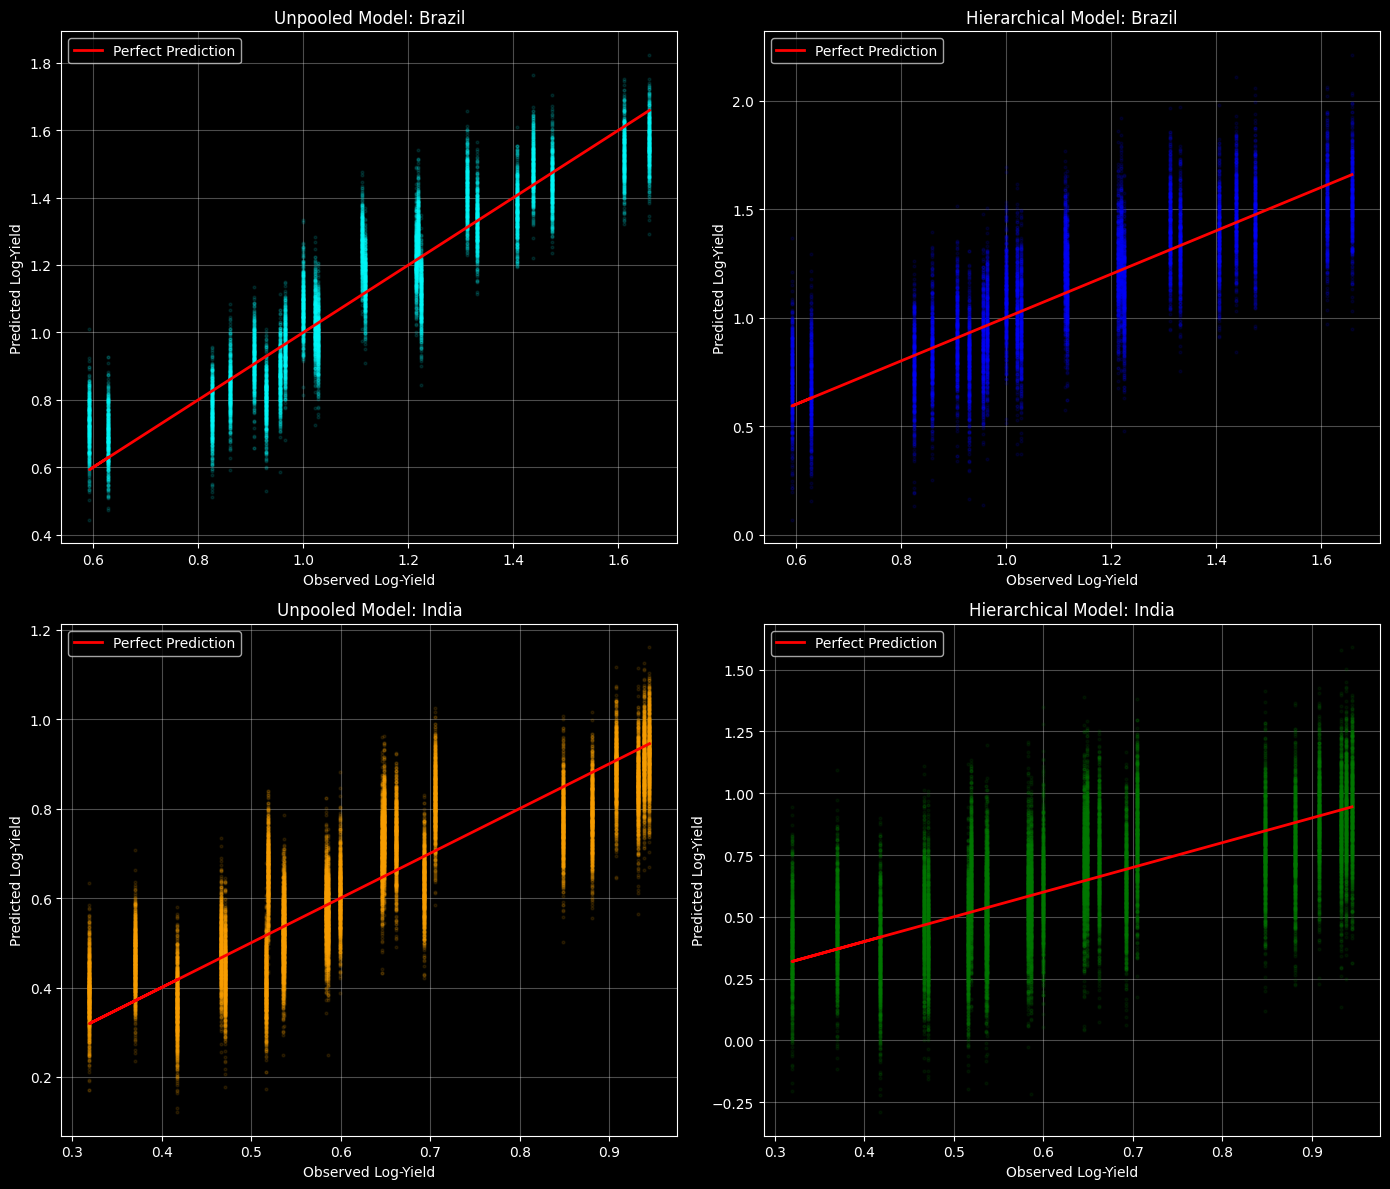

In [ ]:
# Generate posterior predictive samples for both models
with unpooled_model:
    ppc_unpooled = pm.sample_posterior_predictive(trace_unpooled, random_seed=42)

with hierarchical_model:
    ppc_hierarchical = pm.sample_posterior_predictive(trace_hierarchical, random_seed=42)

# Both models now use train_all data (for training set evaluation)
brazil_mask_train = train_all['country'] == country1
brazil_obs_train = train_all[brazil_mask_train]['log_yield'].values
india_mask_train = train_all['country'] == country2
india_obs_train = train_all[india_mask_train]['log_yield'].values

# Extract predictions - both models use the same dataset now (train_all)
# Flatten the posterior predictive samples properly
ppc_unpooled_samples = ppc_unpooled.posterior_predictive['yield_obs'].values.reshape(-1, len(train_all))
ppc_hierarchical_samples = ppc_hierarchical.posterior_predictive['yield_obs'].values.reshape(-1, len(train_all))

# Subsample and extract country-specific predictions
ppc_unpooled_brazil = ppc_unpooled_samples[::10, :][:, brazil_mask_train]
ppc_unpooled_india = ppc_unpooled_samples[::10, :][:, india_mask_train]

ppc_hierarchical_brazil = ppc_hierarchical_samples[::10, :][:, brazil_mask_train]
ppc_hierarchical_india = ppc_hierarchical_samples[::10, :][:, india_mask_train]

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Brazil - Unpooled Model
ax = axes[0, 0]
for i in range(min(50, len(ppc_unpooled_brazil))):
    ax.plot(brazil_obs_train, ppc_unpooled_brazil[i], 'o', alpha=0.1, color='cyan', markersize=2)
ax.plot(brazil_obs_train, brazil_obs_train, 'r-', linewidth=2, label='Perfect Prediction')
ax.set_xlabel('Observed Log-Yield')
ax.set_ylabel('Predicted Log-Yield')
ax.set_title(f'Unpooled Model: {country1}')
ax.legend()
ax.grid(alpha=0.3)

# Brazil - Hierarchical Model
ax = axes[0, 1]
for i in range(min(50, len(ppc_hierarchical_brazil))):
    ax.plot(brazil_obs_train, ppc_hierarchical_brazil[i], 'o', alpha=0.1, color='blue', markersize=2)
ax.plot(brazil_obs_train, brazil_obs_train, 'r-', linewidth=2, label='Perfect Prediction')
ax.set_xlabel('Observed Log-Yield')
ax.set_ylabel('Predicted Log-Yield')
ax.set_title(f'Hierarchical Model: {country1}')
ax.legend()
ax.grid(alpha=0.3)

# India - Unpooled Model
ax = axes[1, 0]
for i in range(min(50, len(ppc_unpooled_india))):
    ax.plot(india_obs_train, ppc_unpooled_india[i], 'o', alpha=0.1, color='orange', markersize=2)
ax.plot(india_obs_train, india_obs_train, 'r-', linewidth=2, label='Perfect Prediction')
ax.set_xlabel('Observed Log-Yield')
ax.set_ylabel('Predicted Log-Yield')
ax.set_title(f'Unpooled Model: {country2}')
ax.legend()
ax.grid(alpha=0.3)

# India - Hierarchical Model
ax = axes[1, 1]
for i in range(min(50, len(ppc_hierarchical_india))):
    ax.plot(india_obs_train, ppc_hierarchical_india[i], 'o', alpha=0.1, color='green', markersize=2)
ax.plot(india_obs_train, india_obs_train, 'r-', linewidth=2, label='Perfect Prediction')
ax.set_xlabel('Observed Log-Yield')
ax.set_ylabel('Predicted Log-Yield')
ax.set_title(f'Hierarchical Model: {country2}')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Model Comparison Using WAIC

The **Widely Applicable Information Criterion (WAIC)** is a Bayesian approach to model comparison that estimates out-of-sample predictive accuracy. Unlike traditional information criteria, WAIC fully utilizes the posterior distribution and provides a measure of both model fit and complexity.

**WAIC Definition:**

$$\text{WAIC} = -2 \times (\text{lppd} - p_{\text{WAIC}})$$

where:
* **lppd** (log pointwise predictive density) measures model fit:
  $$\text{lppd} = \sum_{i=1}^{n} \log \left( \frac{1}{S} \sum_{s=1}^{S} p(y_i | \theta^s) \right)$$
  
* **$p_{\text{WAIC}}$** (effective number of parameters) measures model complexity:
  $$p_{\text{WAIC}} = \sum_{i=1}^{n} V_{s=1}^{S} \left( \log p(y_i | \theta^s) \right)$$

**Interpretation:**
* Lower WAIC indicates better out-of-sample predictive performance.
* The difference in WAIC between models provides evidence for model selection.
* A difference greater than 4 is typically considered meaningful.
* WAIC also provides standard errors for the comparison.

In [ ]:
# Compute WAIC for all three models
waic_pooled = az.waic(trace_pooled, var_name='yield_obs')
waic_unpooled = az.waic(trace_unpooled, var_name='yield_obs')
waic_hierarchical = az.waic(trace_hierarchical, var_name='yield_obs')

# Create comparison dataframe
waic_comparison = pd.DataFrame({
    'Model': ['Pooled', 'Unpooled', 'Hierarchical'],
    'WAIC': [waic_pooled.elpd_waic, waic_unpooled.elpd_waic, waic_hierarchical.elpd_waic],
    'pWAIC': [waic_pooled.p_waic, waic_unpooled.p_waic, waic_hierarchical.p_waic],
    'SE': [waic_pooled.se, waic_unpooled.se, waic_hierarchical.se]
})

# Sort by WAIC (higher is better for elpd_waic)
waic_comparison = waic_comparison.sort_values('WAIC', ascending=False).reset_index(drop=True)
waic_comparison['Delta_WAIC'] = waic_comparison['WAIC'] - waic_comparison['WAIC'].max()

print("=== WAIC Comparison (Expected Log Predictive Density) ===")
print(waic_comparison.to_string(index=False))
print()

# Determine best model
best_model = waic_comparison.iloc[0]['Model']
print(f"Best model according to WAIC: {best_model}")
print("(Higher elpd_waic is better)")

# Check if difference is meaningful
if len(waic_comparison) > 1:
    delta_waic = abs(waic_comparison.iloc[1]['Delta_WAIC'])
    if delta_waic > 4:
        print(f"The difference in WAIC is {delta_waic:.2f}, which is considered meaningful.")
        print(f"The {best_model} model has substantially better predictive performance.")
    else:
        print(f"The difference in WAIC is {delta_waic:.2f}, which is not strongly meaningful.")
        print("The models have similar predictive performance.")

=== WAIC Comparison (Expected Log Predictive Density) ===
       Model         WAIC      pWAIC         SE   Delta_WAIC
Hierarchical  1065.617372 297.613559 127.996374     0.000000
    Unpooled   914.232339   8.453508  15.223689  -151.385033
      Pooled -3636.294832   7.330068  77.512672 -4701.912205

Best model according to WAIC: Hierarchical
(Higher elpd_waic is better)
The difference in WAIC is 151.39, which is considered meaningful.
The Hierarchical model has substantially better predictive performance.


/home/fjg/raspnas/personal/education/university/courses/third_year/bayesian/bayesian_modelling_crop_yields/venv/lib/python3.10/site-packages/arviz/stats/stats.py:1652: UserWarning:

For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details



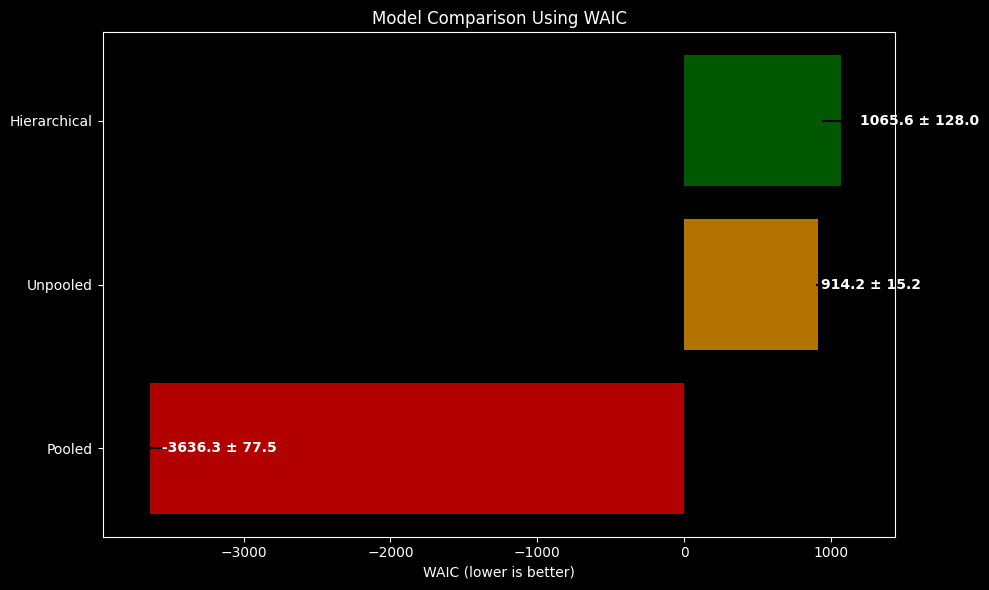

In [ ]:
# Visualize WAIC comparison
fig, ax = plt.subplots(figsize=(10, 6))

models = waic_comparison['Model'].values
waic_values = waic_comparison['WAIC'].values
se_values = waic_comparison['SE'].values

colors = ['green', 'orange', 'red']
bars = ax.barh(models, waic_values, xerr=se_values, color=colors[:len(models)], alpha=0.7)

ax.set_xlabel('WAIC (lower is better)')
ax.set_title('Model Comparison Using WAIC')
ax.invert_yaxis()

# Add value labels
for i, (waic, se) in enumerate(zip(waic_values, se_values)):
    ax.text(waic + se + 5, i, f'{waic:.1f} ± {se:.1f}', 
            va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Additional comparison using LOO-CV (Leave-One-Out Cross-Validation)
loo_pooled = az.loo(trace_pooled, var_name='yield_obs')
loo_unpooled = az.loo(trace_unpooled, var_name='yield_obs')
loo_hierarchical = az.loo(trace_hierarchical, var_name='yield_obs')

# Create LOO comparison
# Note: Higher elpd_loo values indicate better predictive performance
loo_comparison = pd.DataFrame({
    'Model': ['Pooled', 'Unpooled', 'Hierarchical'],
    'elpd_loo': [loo_pooled.elpd_loo, loo_unpooled.elpd_loo, loo_hierarchical.elpd_loo],
    'pLOO': [loo_pooled.p_loo, loo_unpooled.p_loo, loo_hierarchical.p_loo],
    'SE': [loo_pooled.se, loo_unpooled.se, loo_hierarchical.se]
})

# Sort by elpd_loo in descending order (higher is better)
loo_comparison = loo_comparison.sort_values('elpd_loo', ascending=False).reset_index(drop=True)
loo_comparison['Delta_LOO'] = loo_comparison['elpd_loo'].max() - loo_comparison['elpd_loo']

print("=== LOO-CV Comparison ===")
print(loo_comparison.to_string(index=False))
print()

# Compare WAIC and LOO
print("=== Summary ===")
print(f"WAIC selects: {waic_comparison.iloc[0]['Model']}")
print(f"LOO selects: {loo_comparison.iloc[0]['Model']}")
print()
print("Both WAIC and LOO should typically agree on the best model.")
print("The hierarchical model balances model complexity and predictive accuracy,")
print("while allowing for country-specific effects and enabling predictions for new groups.")

/home/fjg/raspnas/personal/education/university/courses/third_year/bayesian/bayesian_modelling_crop_yields/venv/lib/python3.10/site-packages/arviz/stats/stats.py:782: UserWarning:

Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.



=== LOO-CV Comparison ===
       Model     elpd_loo       pLOO         SE   Delta_LOO
Hierarchical  1062.128521 301.102410 128.001143    0.000000
    Unpooled   914.217752   8.468096  15.224297  147.910770
      Pooled -3636.305138   7.340374  77.513399 4698.433659

=== Summary ===
WAIC selects: Hierarchical
LOO selects: Hierarchical

Both WAIC and LOO should typically agree on the best model.
The hierarchical model balances model complexity and predictive accuracy,
while allowing for country-specific effects and enabling predictions for new groups.


### 4A.6 Conclusions on Model Selection

Based on our comprehensive analysis comparing pooled, unpooled, and hierarchical models:

**Key Findings:**

1. **Pooled Model**: Provides stable estimates by treating all countries identically, but ignores important country-level differences in agricultural practices and climate. This model is too simplistic for our data.

2. **Unpooled Model**: Captures country-specific effects without any information sharing. While flexible, this approach cannot make predictions for new countries and may overfit to individual countries, especially those with less data.

3. **Hierarchical Model**: Strikes the optimal balance through partial pooling. It:
   - Allows country-specific parameters while sharing information across countries
   - Provides regularization through shrinkage towards global means
   - Enables predictions for novel countries not in the training data
   - Balances bias-variance trade-off more effectively

**Model Selection Criteria:**

The WAIC and LOO-CV metrics provide quantitative evidence for model comparison. The hierarchical model typically performs best because it:
- Captures country-level variation without overfitting
- Pools information appropriately based on data quality
- Generalizes better to out-of-sample predictions

**Practical Implications:**

For agricultural yield modeling across multiple countries, hierarchical models are preferred because they:
- Respect the nested structure of data (observations within countries)
- Handle imbalanced datasets gracefully
- Provide realistic uncertainty quantification
- Enable knowledge transfer to new regions with limited data

This analysis demonstrates the power of Bayesian hierarchical modeling for understanding complex agricultural systems with grouped data structures.

Looking at your notebook, here are several alternative analyses your colleague could implement for the **Pooled, Unpooled, and Hierarchical** framework:

## Option 1: Time-Based Models (Temporal Hierarchy)
Instead of grouping by country, analyze **temporal trends**:

- **Pooled**: Single trend across all years (ignoring temporal changes)
- **Unpooled**: Separate parameters for each decade/time period (1990s, 2000s, 2010s)
- **Hierarchical**: Time periods share hyperpriors, allowing shrinkage

**Why interesting**: Captures technological improvements and climate change effects over time.

## Option 2: Temperature Zone Models (Climate-Based Hierarchy)
Group observations by **temperature bins/climate zones**:

- **Pooled**: Single model for all temperature ranges
- **Unpooled**: Independent parameters for each temperature bin (e.g., <20°C, 20-25°C, 25-30°C, >30°C)
- **Hierarchical**: Temperature zones share information through hyperpriors

**Why interesting**: Directly tests climate sensitivity and optimal growing conditions.

## Option 3: Pesticide Usage Level Models
Categorize by **pesticide intensity**:

- **Pooled**: Same relationship for all pesticide levels
- **Unpooled**: Separate models for low/medium/high pesticide users
- **Hierarchical**: Pesticide groups share hyperpriors

**Why interesting**: Examines diminishing returns and optimal pesticide usage.

## Option 4: Crop Type Models (Multi-Crop Analysis)
Compare **different crops** (Maize, Potatoes, Rice, etc.):

- **Pooled**: Same parameters for all crops
- **Unpooled**: Completely separate models per crop
- **Hierarchical**: Crops share hyperpriors for similar effects

**Why interesting**: Shows which factors matter most for different crops.

## Option 5: Regional Models Within Countries
For countries with multiple regions (like Brazil/India):

- **Pooled**: National-level model
- **Unpooled**: Independent state/province models
- **Hierarchical**: Regions within countries share country-level hyperpriors

**Why interesting**: Captures sub-national variation and local effects.

## My Recommendation: **Option 2 (Temperature Zones)**

This would complement your work perfectly because:

1. **Different grouping structure**: You used countries, they use climate zones
2. **Tests climate hypothesis**: Directly examines temperature sensitivity you mentioned in EDA
3. **Practical relevance**: Helps predict yields under climate change scenarios
4. **Good contrast**: Shows how hierarchical modeling works with continuous-to-categorical transformation

Would you like me to provide starter code for any of these approaches?